# German Credit Dataset

***Abstract***: This dataset classifies people described by a set of attributes as good or bad credit risks

***Attributes***:

- **status_current_account** (categorical): Range of the status of existing checking account in DM
- **duration** (numerical): Duration in month
- **credit_history** (categorical): Credit history (no credit taken, all credit paid back, etc.)
- **purpose** (categorical): Purpose of the credit
- **credit_amount** (numerical): Amount of money requested
- **savings** (categorical): Range of user savings
- **employed_since** (categorical): Range of employed since X
- **installment_rate** (numerical): Installment rate in percentage of disposable income 
- **status_and_sex** (categorical): Personal status and gender
- **other_debtors** (categorical): Other debtors
- **present_residence_since** (numerical): Time living in their residence
- **property** (categorical): Which properties has the user
- **age** (numerical): User age
- **other_installment_plans** (categorical): Bank, stores or none
- **housing** (categorical): Rent, own or free
- **n_credits** (numerical): Number of existing credits at this bank
- **job** (categorical): Kind of job
- **n_maintenance_people** (numerical): Number of people being liable to provide maintenance for
- **telephone** (bool): has registered telephone
- **foreign** (bool): If the user is foreign
- **Class** (bool): Before processing: Good (1) or Bad (2) credit risk. After processing (needed for XGBoost): Good (1) or Bad (0) credit risk.

More info: https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)


***Data background***:

- Stratified sample of 1000 credits (300 bad ones and 700 good ones) from the years 1973 to 1975 from a large regional bank in southern Germany. EU Project: Statlog
- All the credits records in the data are part of normal bank business, i.e. all debtors must have passed some checks of creditworthiness before being granted the credit that are unknown.
- According to the authors, customers with “good” credits perfectly complied with the conditions of the contract while customers with “bad” credits did not comply with the contract as required.

More info (chapter 3): http://www1.beuth-hochschule.de/FB_II/reports/Report-2019-004.pdf

## 1. Needed imports

In [1]:
# Libraries and functions
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import category_encoders as ce
import numpy as np
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBClassifier, plot_tree

# Own modules
import apply_metrics
from preprocessing import get_data, clean_data, process_data, split_data, get_res_df, decoding, get_df4chi
from statistical_measures import get_entropy, get_mi, get_gr, get_suc, get_chi2, get_mannwhitneyu
from machine_learning import train_model, test_model, print_results, search_best_attributes, search_best_attributes_for_fairness, forward_regression, backward_regression
from visualization import show_histogram, compare_histogram, show_correlation_matrix, plot_dictionaries, plot_horizontal_dictionaries

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'


## 2. Other Functions

### 2.1 Data

### 2.2 Visualization

### 2.3 Statistics

### 2.4 Machile learning

### 2.5 Feature Selection

### 2.6 Fairness

In [2]:
def get_cond_df(df, numerical_column, n):
    return df[df[numerical_column] >= n]

In [3]:
def conditional_fairness(res_df, column_name, fairness_metric, protected_attribute = 'gender', increment = 100):

    results = []

    for i in range(res_df[column_name].min(), res_df[column_name].max(), increment): # max: 15857 min: 433
        cond_df = get_cond_df(res_df, column_name, i)
        
        if cond_df.shape[0] <= 10 or len(cond_df[protected_attribute].unique()) < 2:
            break

        cond_res = apply_metrics.fair_metrics(cond_df, protected_attribute = protected_attribute)

        # print(i, cond_res[fairness_metric])
        results.append(cond_res[fairness_metric])
        last_i = i

    plt.plot(range(res_df[column_name].min(), last_i + increment, increment), results)
    plt.title('Conditional Fairness')
    plt.xlabel(column_name)
    plt.ylabel(fairness_metric)
    plt.show()

## 3. Data visualization and correlation tests

In [2]:
df = get_data('/Users/app245/Documents/Datasets/GermanCredit/german.data')
df = clean_data(df)
df

,status_current_account,duration,credit_history,purpose,credit_amount,savings,employed_since,installment_rate,status_and_sex,other_debtors,...,property,age,other_installment_plans,housing,n_credits,job,n_maintenance_people,telephone,foreign,Class
0,< 0,6,critical / other banks credit,radio/tv,1169,unknown,>= 7,4,male single,none,...,real estate,67,none,own,2,skilled/official,1,yes,yes,1
1,0 <= X < 200,48,current credit paid,radio/tv,5951,< 100,1 <= X < 4,2,female divorced/separated/married,none,...,real estate,22,none,own,1,skilled/official,1,none,yes,2
2,no checking account,12,critical / other banks credit,education,2096,< 100,4 <= X < 7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,1
3,< 0,42,current credit paid,furniture,7882,< 100,4 <= X < 7,2,male single,guarantor,...,building society/life insurance,45,none,for free,1,skilled/official,2,none,yes,1
4,< 0,24,delay,new car,4870,< 100,1 <= X < 4,3,male single,none,...,unknown / no property,53,none,for free,2,skilled/official,2,none,yes,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking account,12,current credit paid,furniture,1736,< 100,4 <= X < 7,3,female divorced/separated/married,none,...,real estate,31,none,own,1,unskilled resident,1,none,yes,1
996,< 0,30,current credit paid,car used,3857,< 100,1 <= X < 4,4,male divorced/separated,none,...,building society/life insurance,40,none,own,1,management/self-employed/highly qualified/officer,1,yes,yes,1
997,no checking account,12,current credit paid,radio/tv,804,< 100,>= 7,4,male single,none,...,car or other,38,none,own,1,skilled/official,1,none,yes,1
998,< 0,45,current credit paid,radio/tv,1845,< 100,1 <= X < 4,4,male single,none,...,unknown / no property,23,none,for free,1,skilled/official,1,yes,yes,2


In [6]:
df_females = df[df['status_and_sex'] == 'female divorced/separated/married']
df_males = df[df['status_and_sex'] != 'female divorced/separated/married']

### 3.1 Histograms

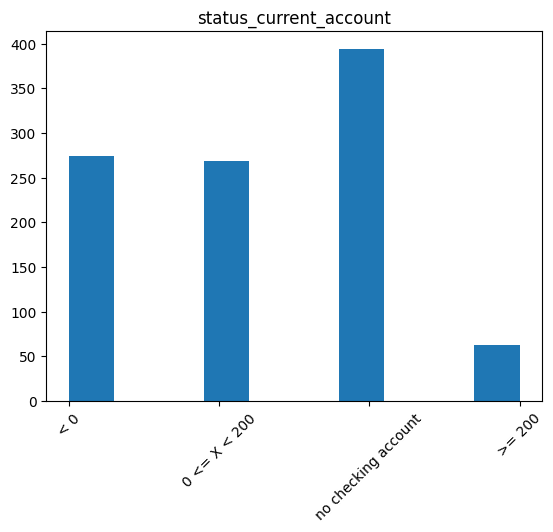

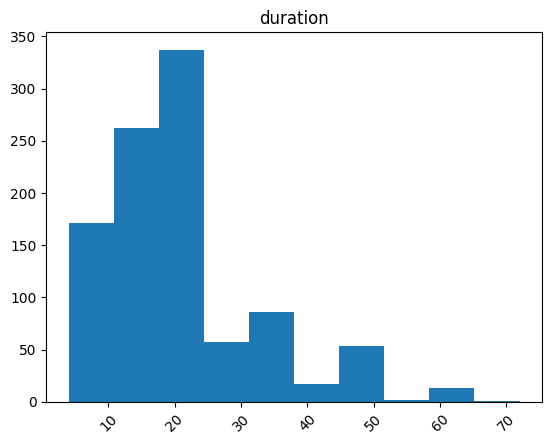

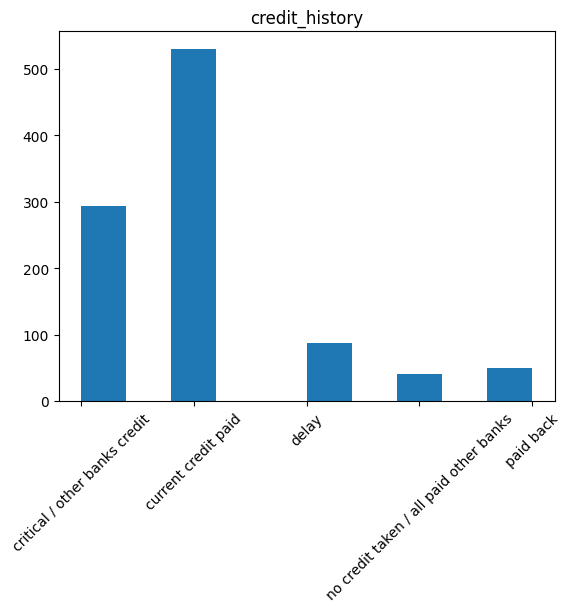

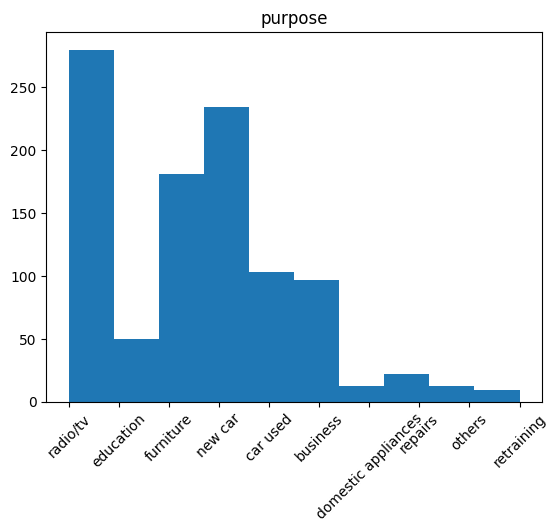

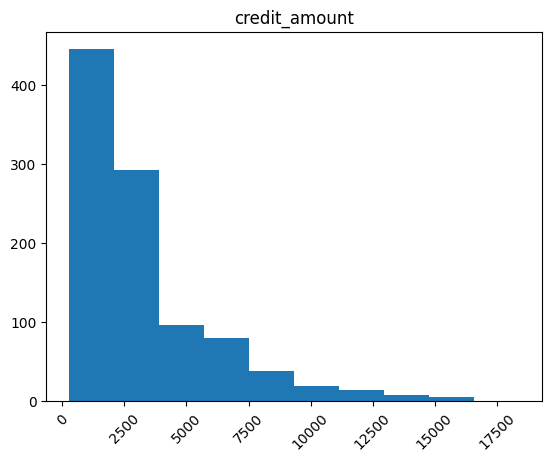

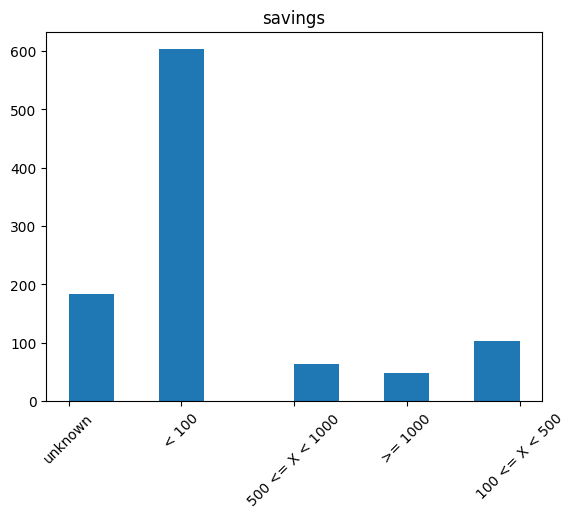

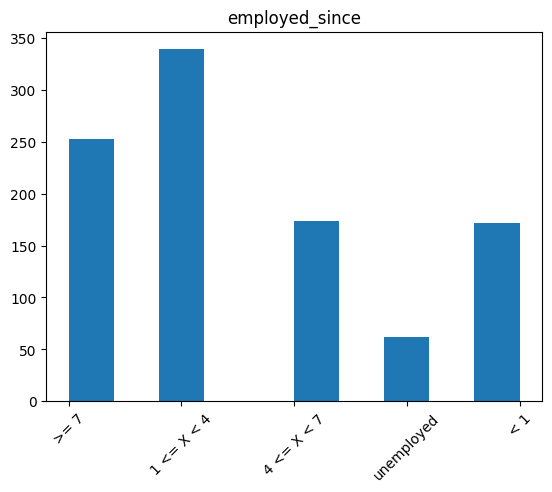

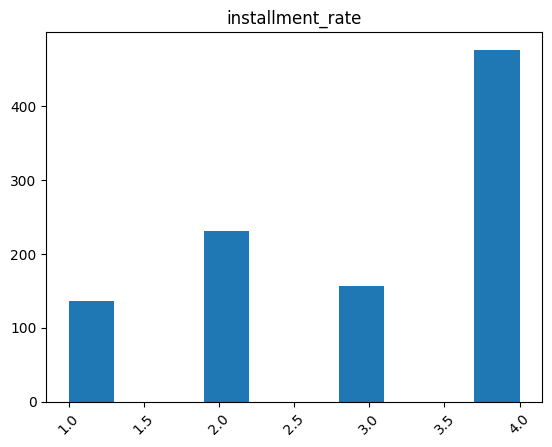

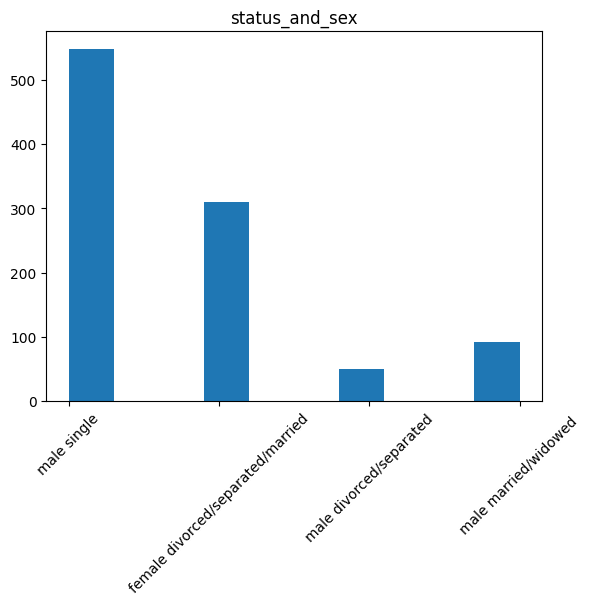

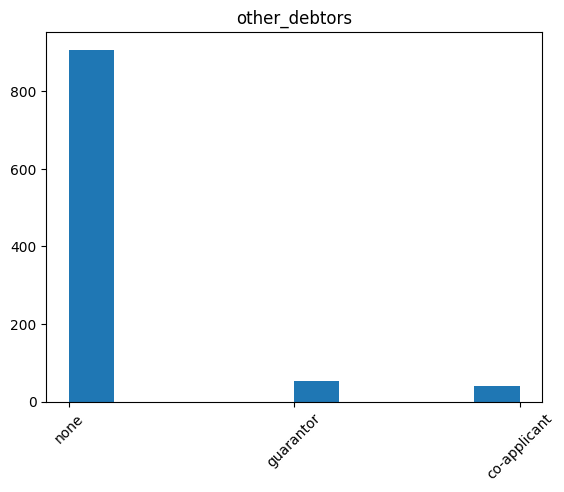

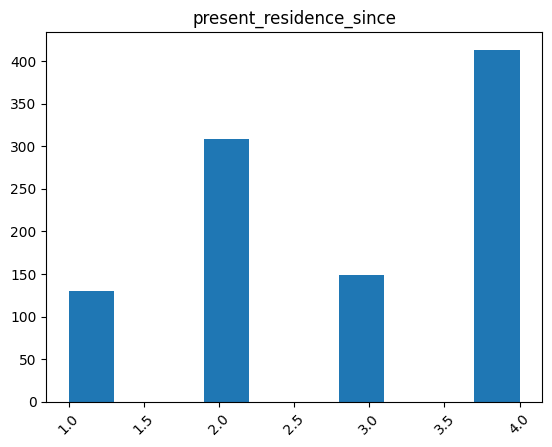

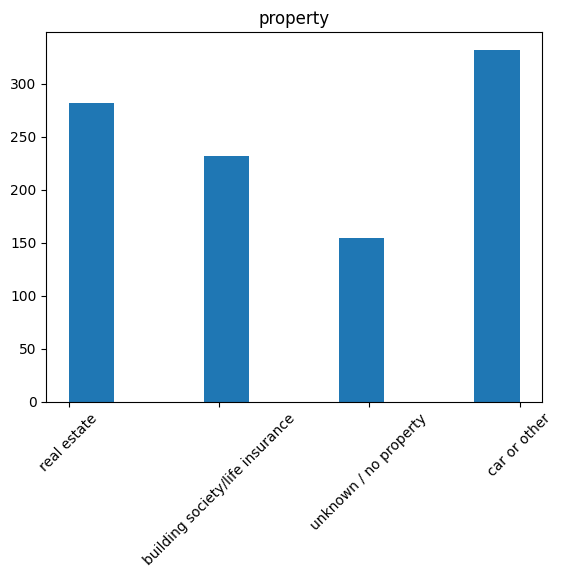

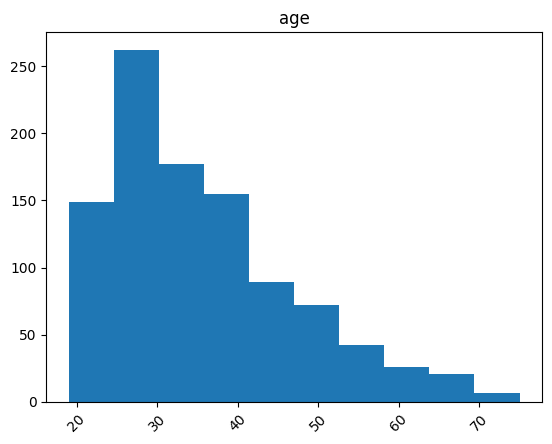

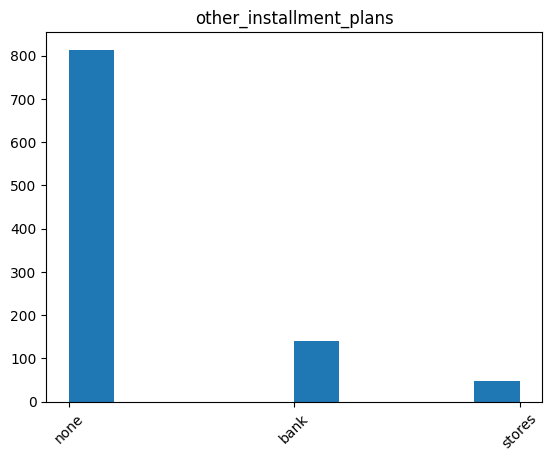

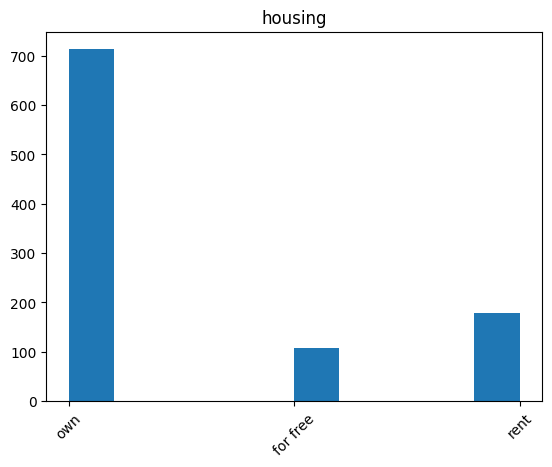

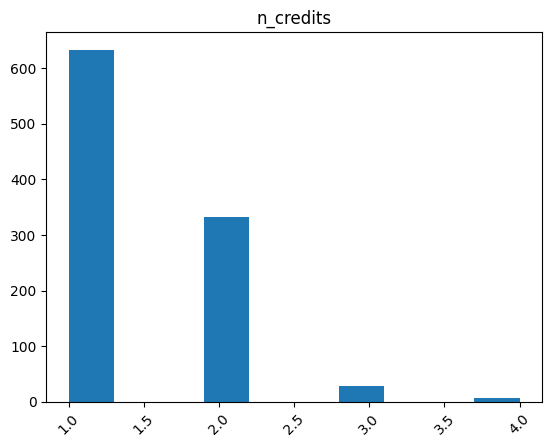

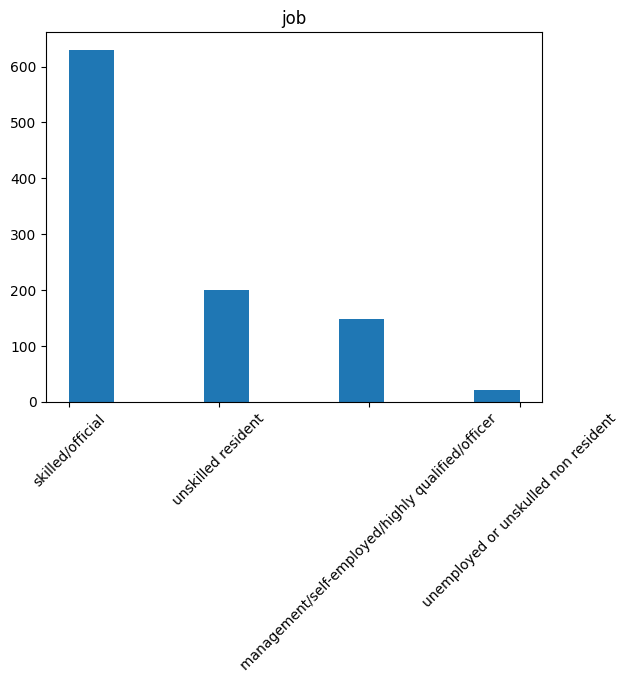

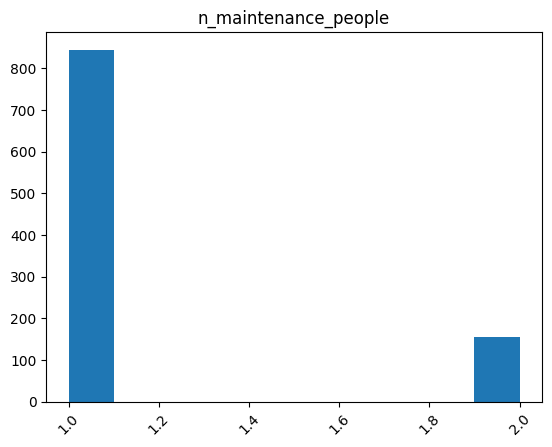

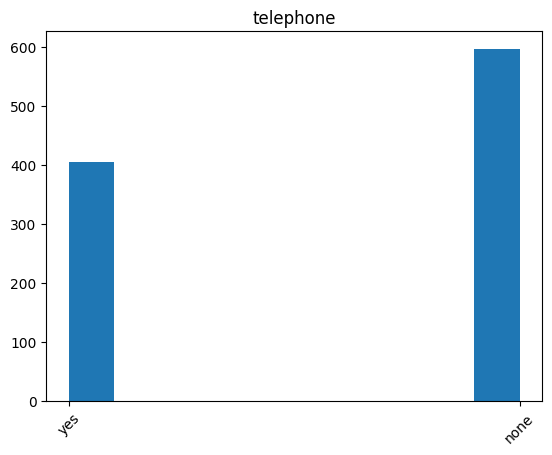

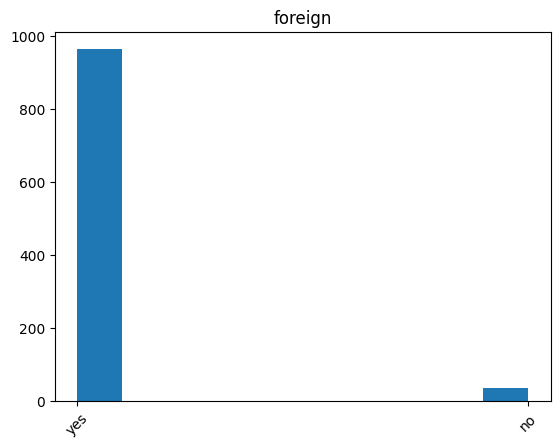

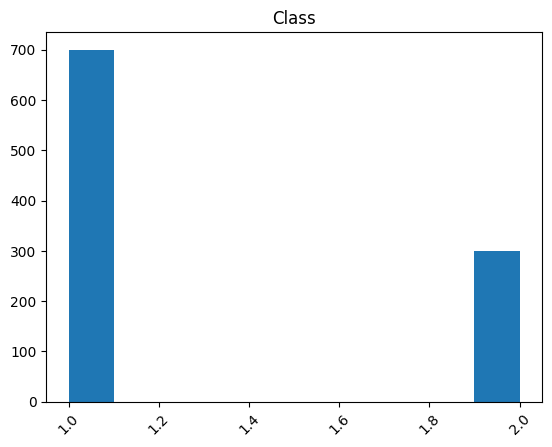

In [7]:
for col_name in df.columns:
    show_histogram(df, col_name)

### 3.2 Correlation matrix

/Users/app245/Library/CloudStorage/GoogleDrive-angelpavonperez@gmail.com/My Drive/PhD/Work/PhD/experiments/Covariance/visualization.py:24: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df.corr())


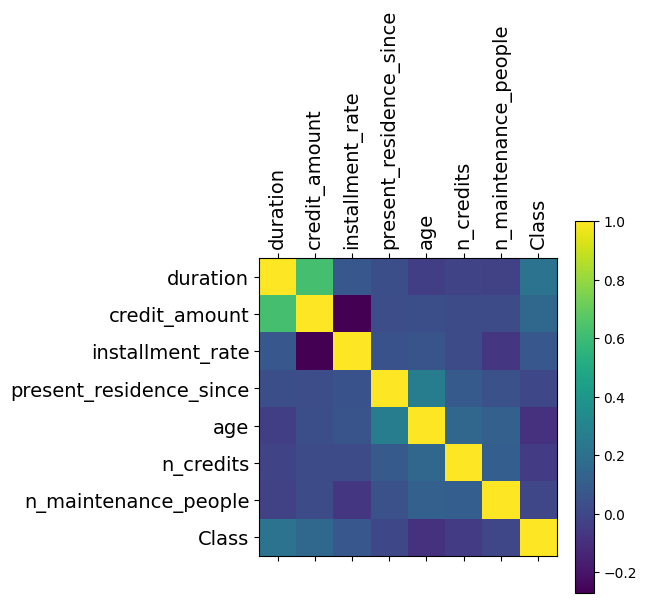

In [8]:
show_correlation_matrix(df)

/usr/local/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/usr/local/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/usr/local/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/usr/local/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/usr/local/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and wil

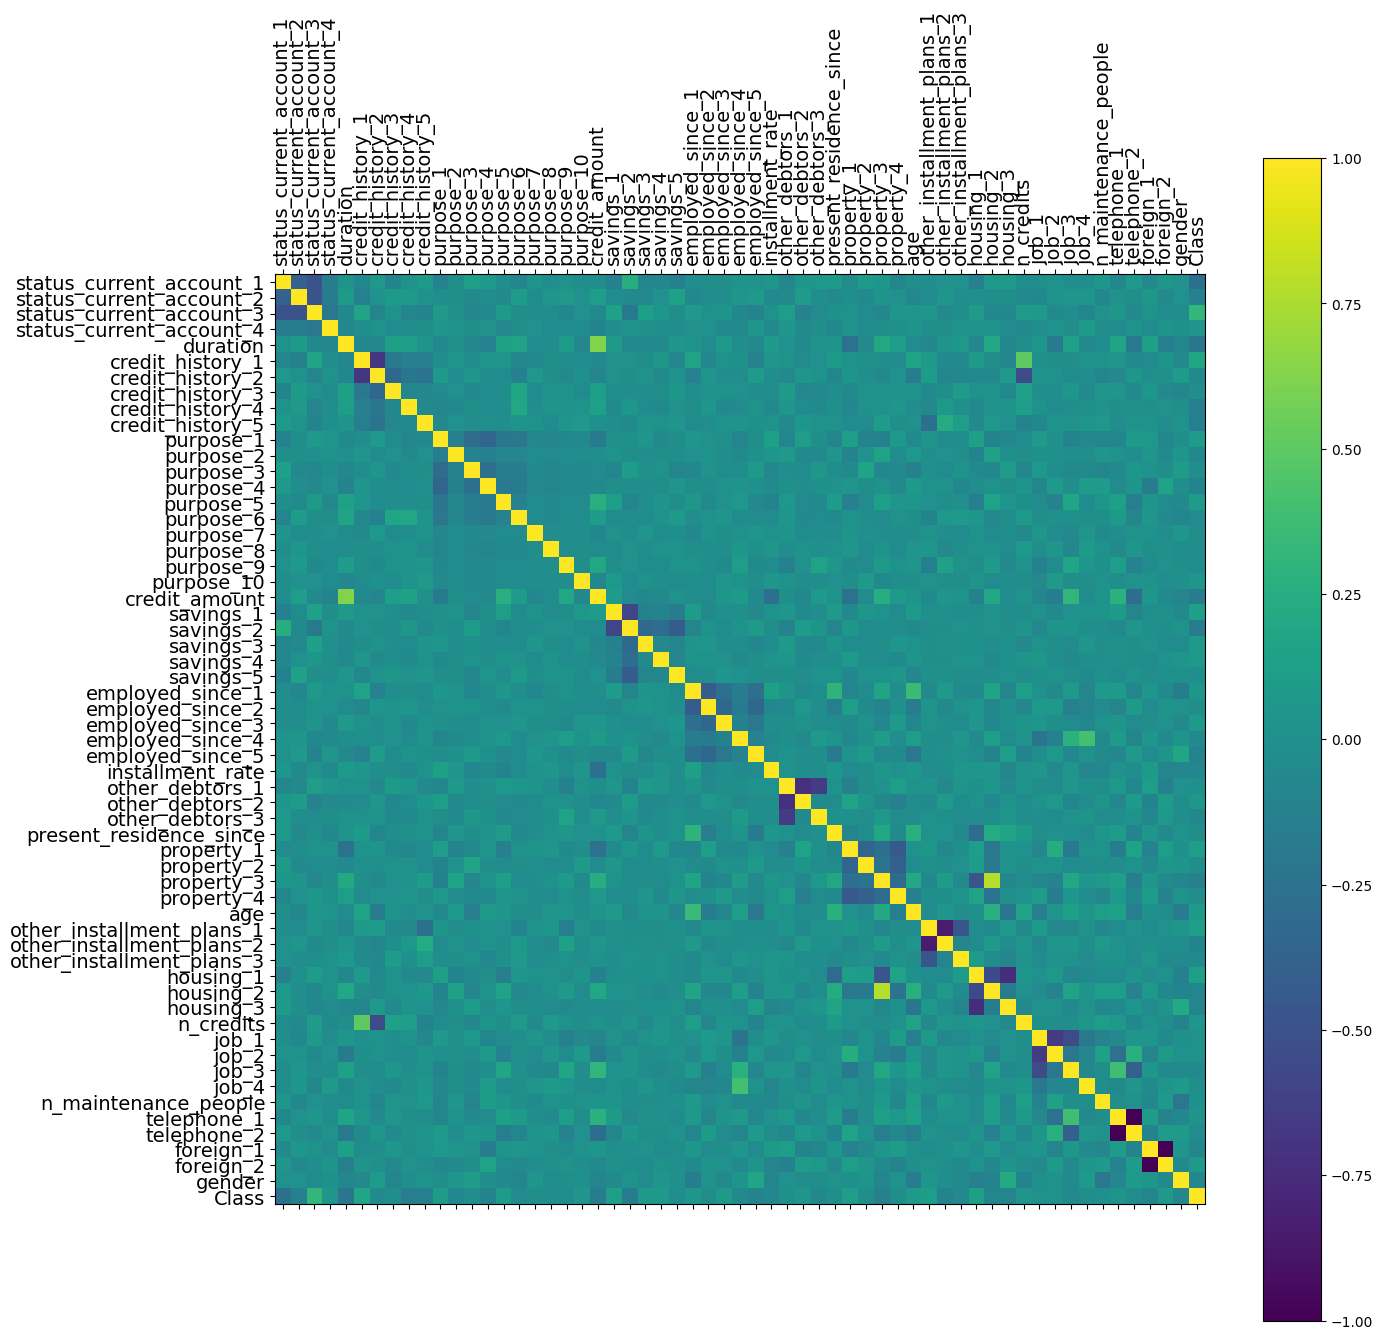

In [9]:
df_preprocessed = process_data(df)
show_correlation_matrix(df_preprocessed, [15,15])

### 3.3 Comparing males and females

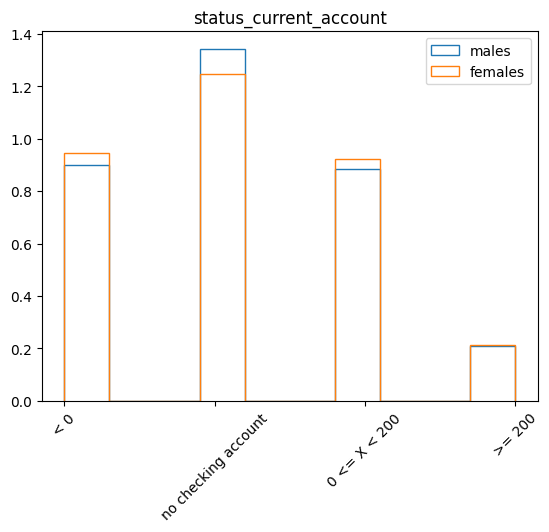

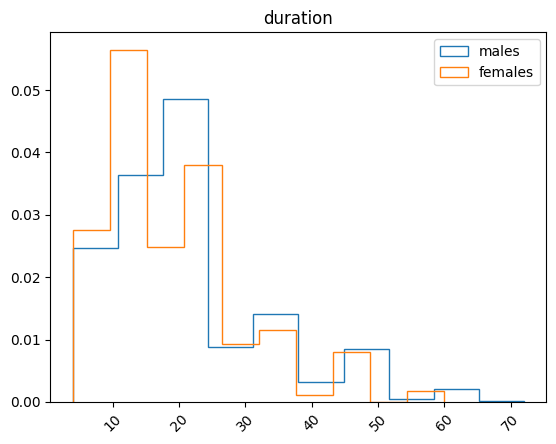

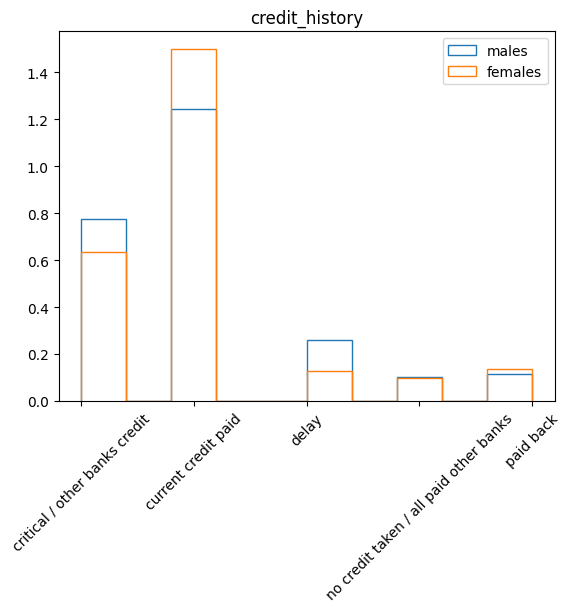

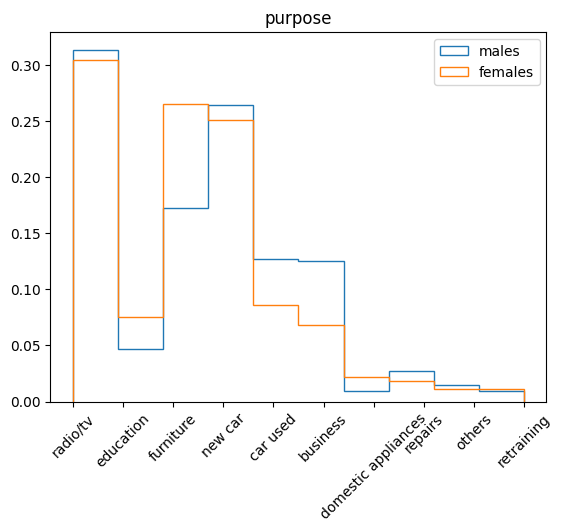

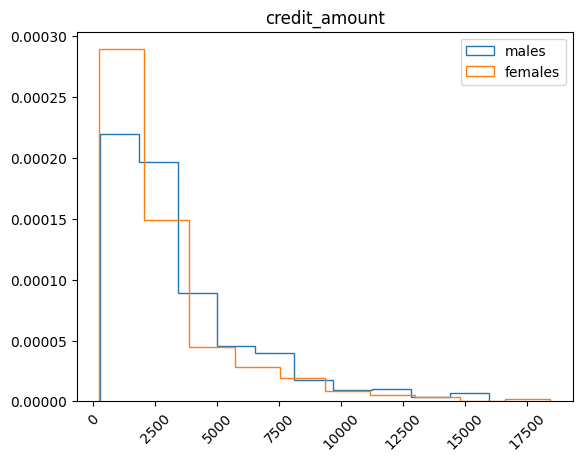

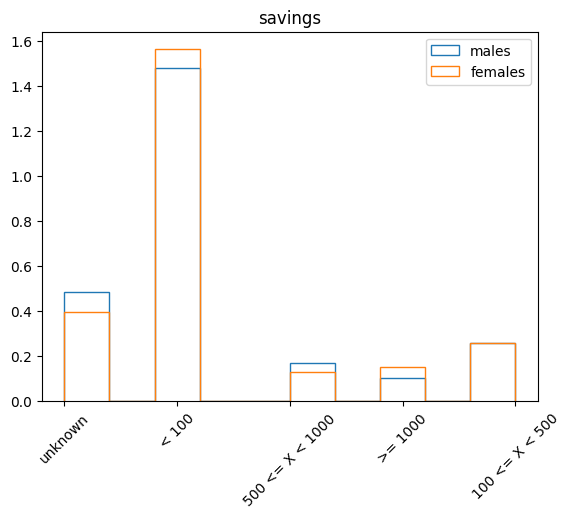

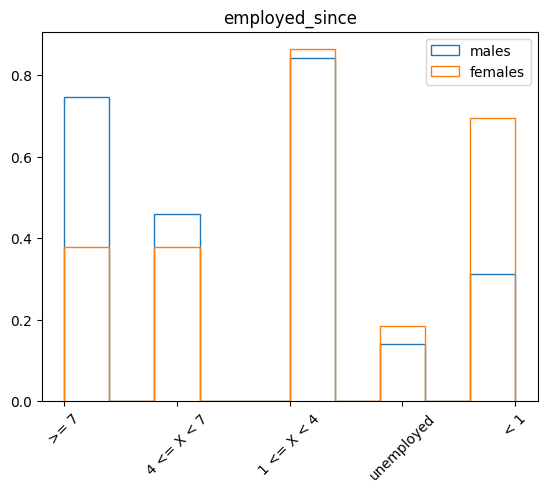

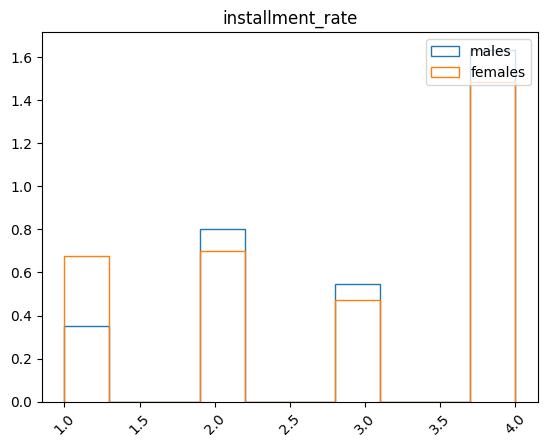

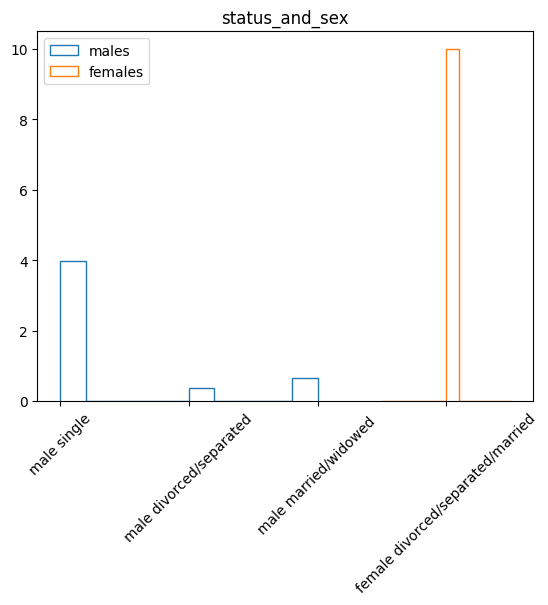

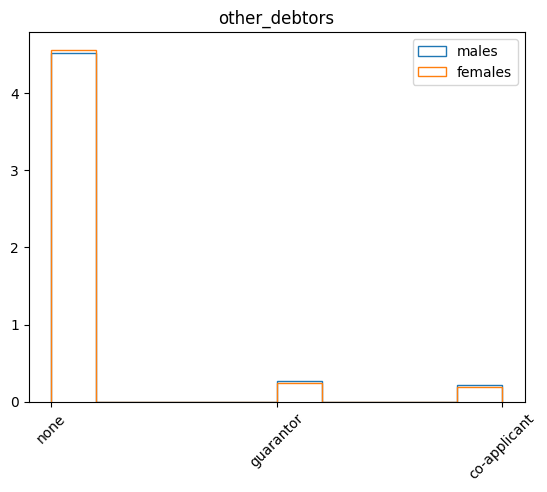

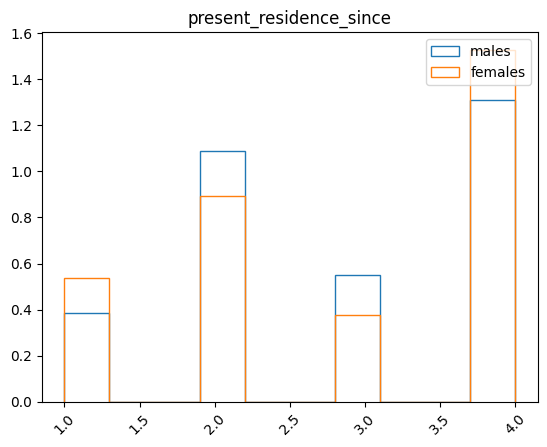

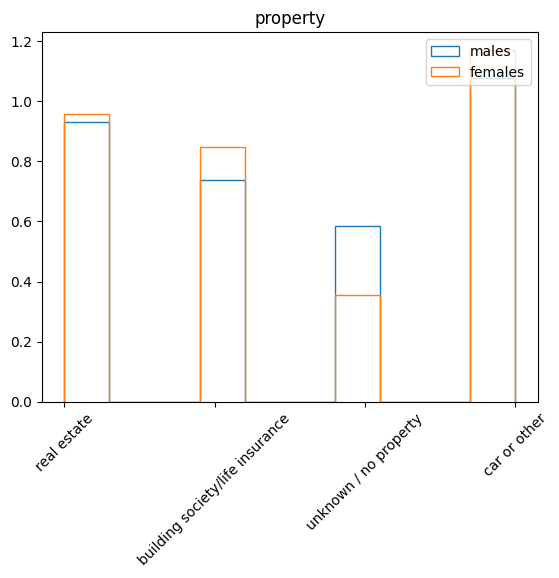

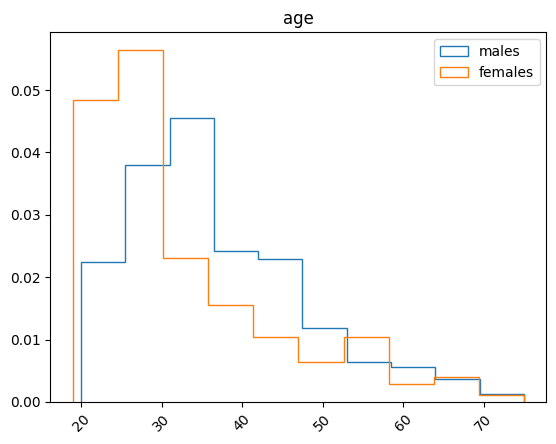

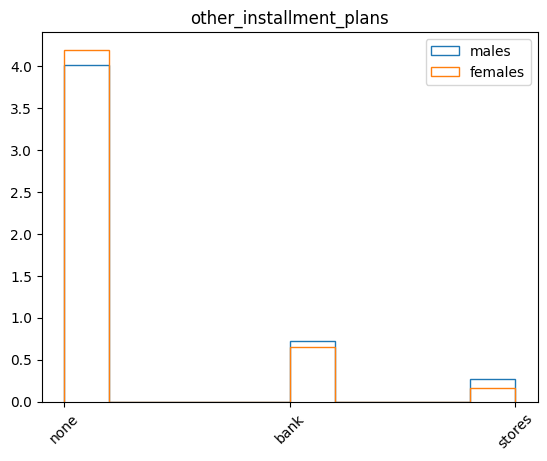

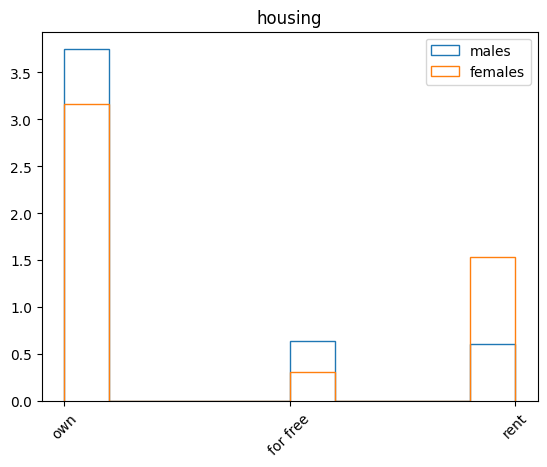

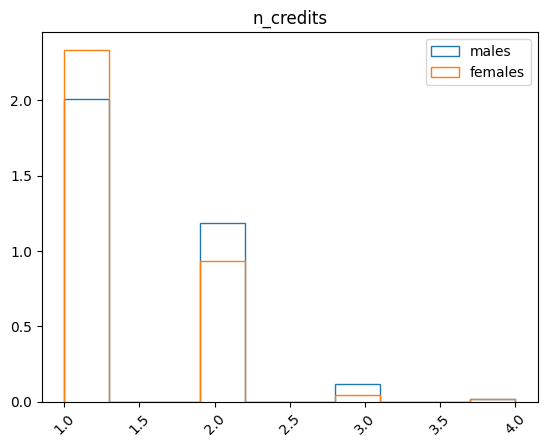

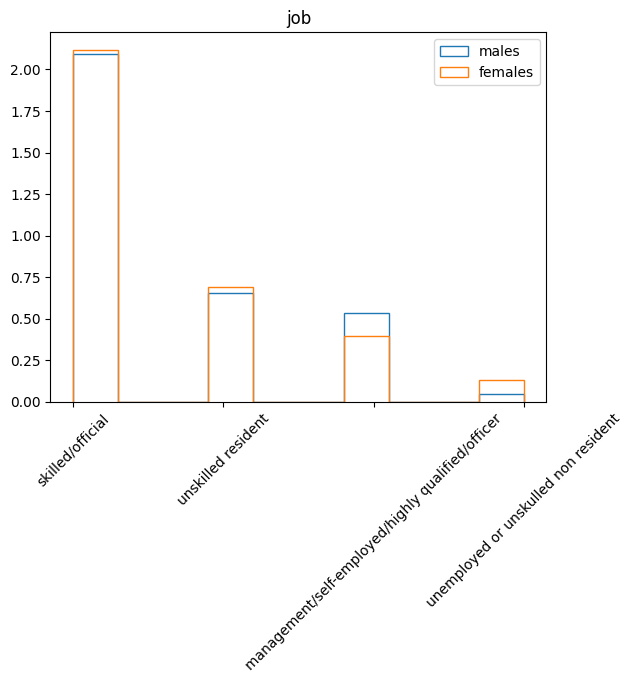

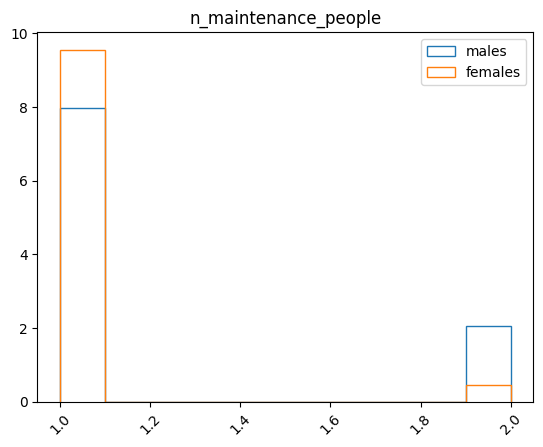

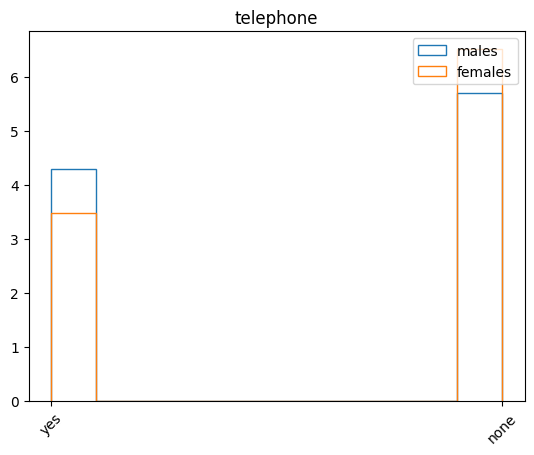

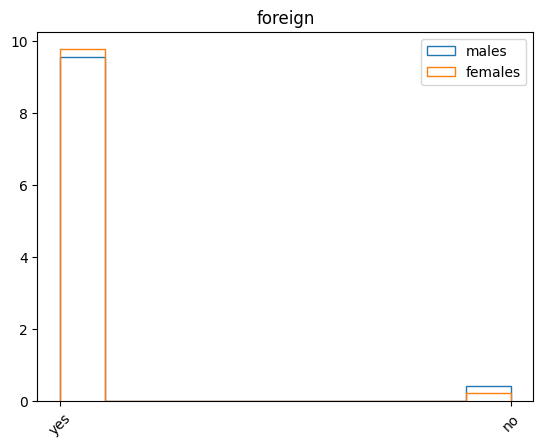

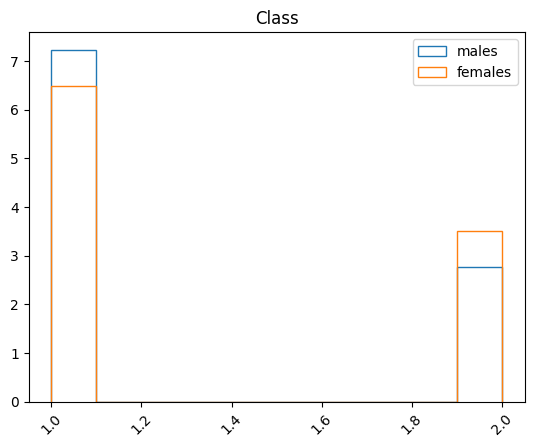

In [10]:
for col_name in df.columns:
    compare_histogram(df_males,df_females, col_name)

### 3.4 Statistical tests

In [3]:
df4chi = get_df4chi(df, dataset='german')

#### 3.4.1 Mann-Whitney U test

In [14]:
get_mannwhitneyu(df4chi, class_name = 'status_and_sex', alpha = 0.05)

({'age': 1.937247510041347e-12,
  'n_maintenance_people': 1.2789588727091533e-10,
  'credit_amount': 0.00025073200547917737,
  'n_credits': 0.0022944431392875925,
  'installment_rate': 0.014920345349459692,
  'duration': 0.02100200222320183},
 {'present_residence_since': 0.5420993175453165})

#### 3.4.2 Chi Square test

In [15]:
get_chi2(df4chi, class_name = 'status_and_sex', alpha = 0.05)

({'status_and_sex': 1.85898053049045e-218,
  'housing': 1.922318250514252e-12,
  'employed_since': 4.162437692763249e-10,
  'purpose': 0.006212800162384857,
  'credit_history': 0.009163176172947199,
  'telephone': 0.019670283908208543,
  'Class': 0.020739913068713305,
  'job': 0.04006053296837244,
  'property': 0.042668563964701534},
 {'foreign': 0.15042257119484756,
  'other_installment_plans': 0.25467307042786047,
  'savings': 0.3434713230242521,
  'status_current_account': 0.8633118921649433,
  'other_debtors': 0.9105013560908615})

### 3.5 FSS

#### 3.5.1 MI

In [14]:
get_mi(df4chi, class_name = 'status_and_sex')

{'status_and_sex': 0.619100664425587,
 'housing': 0.025836712540534768,
 'employed_since': 0.02465897037419172,
 'purpose': 0.011516123565696281,
 'credit_history': 0.00707028502063331,
 'property': 0.004307145169405058,
 'job': 0.003960052834578523,
 'telephone': 0.0029145203061008707,
 'Class': 0.0028055597181083913,
 'savings': 0.0022482129053548183,
 'other_installment_plans': 0.0014444300616710884,
 'foreign': 0.0014318897722574095,
 'status_current_account': 0.0003721927890665555,
 'other_debtors': 9.481061703984356e-05}

#### 3.5.2 Gain Ratio

In [15]:
get_gr(df4chi, class_name = 'status_and_sex')

{'status_and_sex': 0.9999999999999998,
 'housing': 0.03272529587241511,
 'employed_since': 0.016506807740923862,
 'foreign': 0.009045996916246536,
 'purpose': 0.006230319466652604,
 'credit_history': 0.005958541138274353,
 'Class': 0.004592770781777125,
 'telephone': 0.004320366601434912,
 'job': 0.004042115999023032,
 'property': 0.0031902441781784248,
 'other_installment_plans': 0.002466957469588927,
 'savings': 0.0019217941980628212,
 'status_current_account': 0.0002979732843602394,
 'other_debtors': 0.00025402395297846765}

#### 3.5.3 Symmetrical Uncertainty coefficient

In [16]:
get_suc(df4chi, class_name = 'status_and_sex')

{'status_and_sex': 0.9999999999999998,
 'housing': 0.03668415319826804,
 'employed_since': 0.02334060697091919,
 'purpose': 0.00933424086569366,
 'credit_history': 0.00783115822767856,
 'job': 0.004953785613603357,
 'Class': 0.004562015658277557,
 'telephone': 0.0045057096536744844,
 'property': 0.004374513622501597,
 'foreign': 0.0036838363453808158,
 'savings': 0.0025134417248704743,
 'other_installment_plans': 0.0023981676943584567,
 'status_current_account': 0.00039845458508666755,
 'other_debtors': 0.00019108578951072615}

In [4]:
def plot_dictionaries(list_dict, title='chart plot', labels = []):

    fig, axes = plt.subplots(1, len(list_dict), figsize=(9,4))
    fig.suptitle(title)
        
    for i,ax in enumerate(axes):
        d = list_dict[i]
        ax.bar(range(len(d)), list(d.values()), align='center')
        ax.set_title(labels[i])
        if labels[i] != 'Chi-Square' and labels[i] != 'Mann-Whitney':
            ax.set_yticks(np.arange(0, 0.04, 0.01))
        else:
            ax.set_yticks(np.arange(0, 1, 0.1))
        ax.set_xticks(range(len(d.keys())))
        ax.set_xticklabels(d.keys(), rotation=90)
        
    for ax in axes.flat:
        ax.set(xlabel='attributes', ylabel='p-value')

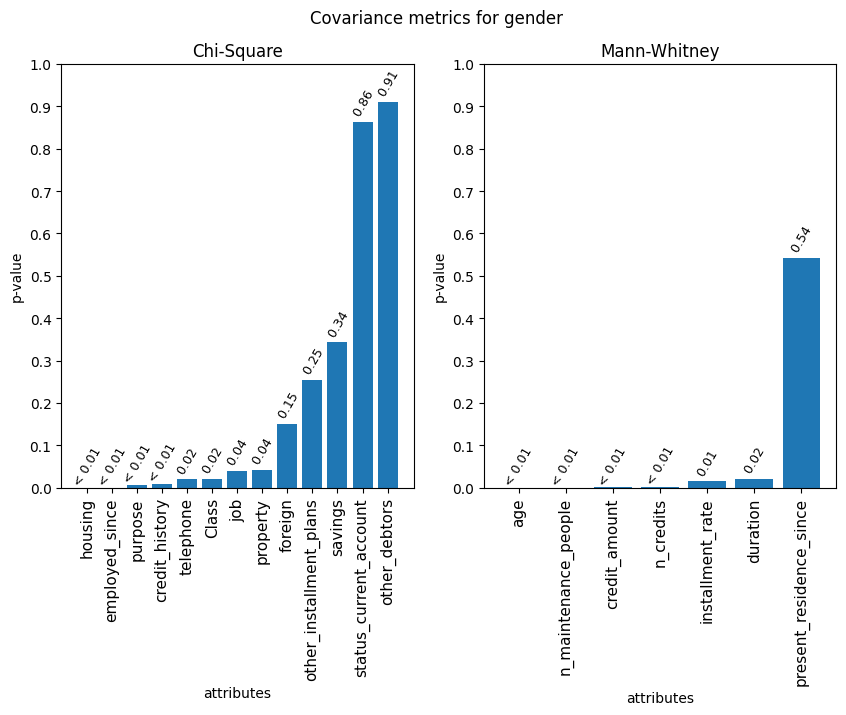

In [23]:
def plot_dictionaries(list_dict, title='chart plot', labels=[]):
    fig, axes = plt.subplots(1, len(list_dict), figsize=(10, 5.5))
    fig.suptitle(title)
    for i, ax in enumerate(axes):
        d = list_dict[i]
        x = range(len(d))
        y = list(d.values())
        ax.bar(x, y, align='center')
        ax.set_title(labels[i])
        if labels[i] == 'Chi-Square':
            ax.set_yticks(np.arange(0, 1.1, 0.1))
        elif labels[i] == 'Mann-Whitney':
            ax.set_yticks(np.arange(0, 1.1, 0.1))
        else:
            ax.set_yticks(np.arange(0, 0.04, 0.01))
        ax.set_xticks(x)
        ax.set_xticklabels(d.keys(), rotation=90, fontsize=11)
        for j, v in enumerate(y):
            if v == 1:
                ax.text(j, v, "0.99", ha='center', va='bottom', fontsize=9, rotation=60)
            elif v >= 0.01 and v != 1:
                ax.text(j, v, f" {v:.2f}", ha='center', va='bottom', fontsize=9, rotation=60)
            else:
                ax.text(j, v, "< 0.01", ha='center', va='bottom', fontsize=9, rotation=60)
                
    for ax in axes.flat:
        ax.set(xlabel='attributes', ylabel='p-value')

plot_dictionaries([chi2, mannU], labels=['Chi-Square', 'Mann-Whitney'], title = 'Covariance metrics for gender')

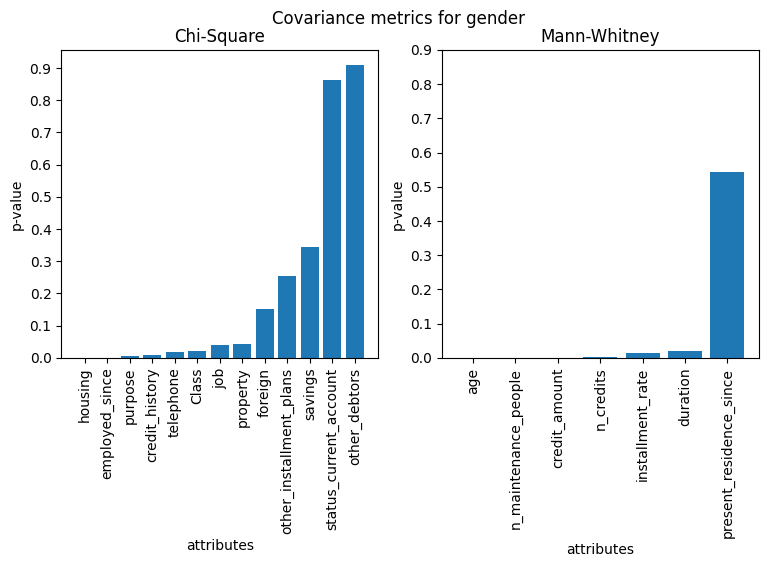

In [5]:
mi = get_mi(df4chi, class_name = 'status_and_sex')
del mi['status_and_sex']
gr = get_gr(df4chi, class_name = 'status_and_sex')
del gr['status_and_sex']
suc = get_suc(df4chi, class_name = 'status_and_sex')
del suc['status_and_sex']
dep, ind = get_chi2(df4chi, class_name = 'status_and_sex', alpha = 0.01)
chi2 = {**dep, **ind}
del chi2['status_and_sex']

dep, ind = get_mannwhitneyu(df4chi, class_name = 'status_and_sex', alpha = 0.01)
mannU = {**dep, **ind}
plot_dictionaries([chi2, mannU], labels=['Chi-Square', 'Mann-Whitney'], title = 'Covariance metrics for gender')

### 3.6 Key variables to find gender

Experiment for finding the best explainable model for gender to explain relation with other attributes.

In [272]:
df2 = df.copy()

dependent_attributes, independent_attributes = get_chi2(df4chi, class_name = 'status_and_sex', alpha = 0.01)
diff_dis_attributes, same_dis_attributes = get_mannwhitneyu(df4chi, class_name = 'status_and_sex', alpha = 0.01)

dependent_attributes = {**dependent_attributes, **diff_dis_attributes, **independent_attributes, **same_dis_attributes}

attributes = [k for k,v in dependent_attributes.items()]
df2 = process_data(df2[attributes])
df2.drop('Class', inplace=True, axis=1)

best_clf, best_attributes, best_acc = search_best_attributes(df2, class_name = 'gender', clf = XGBClassifier())
print(f'\n Best attributes: {best_attributes}\n Best accuracy: {best_acc}')

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. 

	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
	 20
	 21
	 22
	 23
	 24
	 25
	 26
	 27
	 28
	 29
	 30
	 31
	 32
	 33
	 34
	 35
	 36
	 37
	 38
	 39
	 40
	 41
	 42
	 43
	 44
	 45
	 46
	 47
	 48
	 49
	 50
	 51
	 52
	 53
	 54
	 55
	 56
	 57

 Best attributes: ['job_4', 'housing_2', 'purpose_6', 'housing_1', 'job_2', 'telephone_1', 'other_debtors_2', 'savings_4', 'telephone_2']
 Best accuracy: 0.795


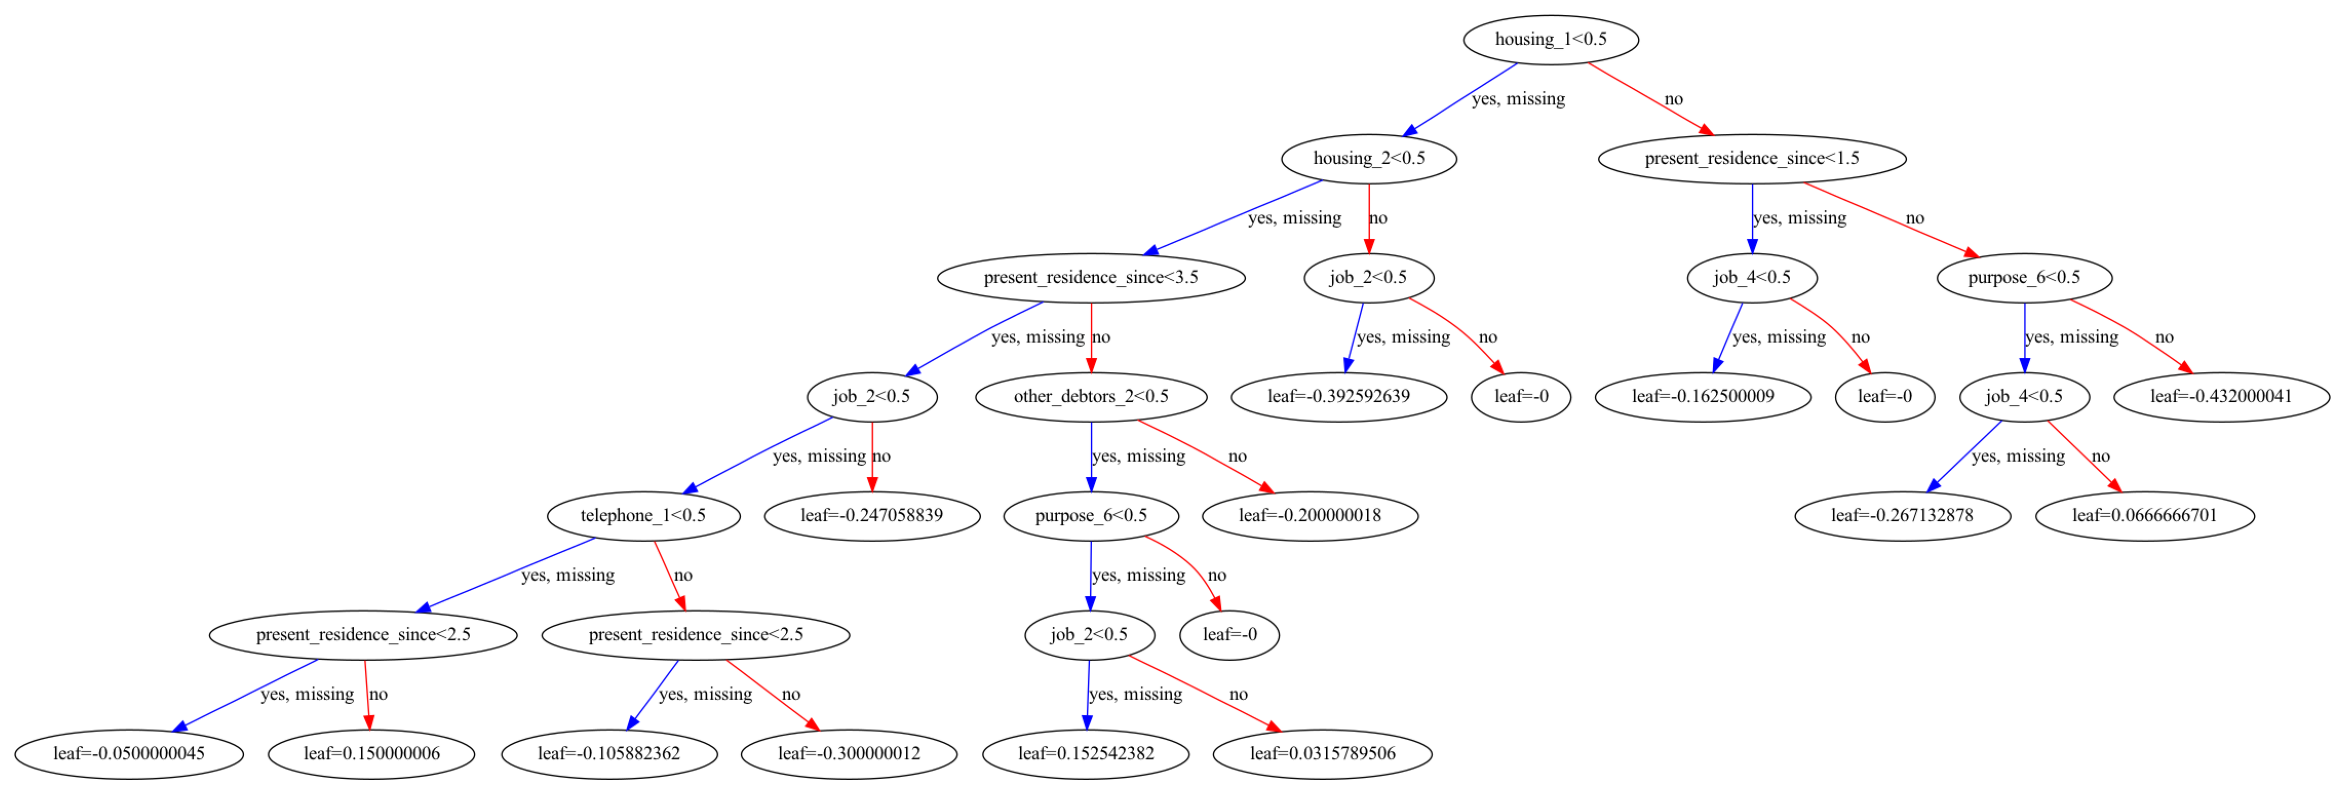

In [273]:
# plt.figure(figsize=(17,10))
# tree.plot_tree(best_clf, class_names = ['males', 'females'], feature_names = best_attributes, 
#                filled = True, proportion = True, fontsize= 10)
# pass
from xgboost import plot_tree

fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(best_clf, ax=ax)
plt.show()

In [21]:
best_clf.feature_importances_

array([0.02742817, 0.93880193, 0.03376991])

In [25]:

decoding(df, df2, ignore_columns = ['gender', 'Class', 'age', 'n_maintenance_people', 'credit_amount', 'n_credits'])

{'housing_1': 'own',
 'housing_2': 'for free',
 'housing_3': 'rent',
 'employed_since_1': '>= 7',
 'employed_since_2': '1 <= X < 4',
 'employed_since_3': '4 <= X < 7',
 'employed_since_4': 'unemployed',
 'employed_since_5': '< 1',
 'purpose_1': 'radio/tv',
 'purpose_2': 'education',
 'purpose_3': 'furniture',
 'purpose_4': 'new car',
 'purpose_5': 'car used',
 'purpose_6': 'business',
 'purpose_7': 'domestic appliances',
 'purpose_8': 'repairs',
 'purpose_9': 'others',
 'purpose_10': 'retraining',
 'credit_history_1': 'critical / other banks credit',
 'credit_history_2': 'current credit paid',
 'credit_history_3': 'delay',
 'credit_history_4': 'no credit taken / all paid other banks',
 'credit_history_5': 'paid back'}

**Check which attributes are the most common selected:**

In [ ]:
df2 = df.copy()

dependent_attributes, independent_attributes = get_chi2(df4chi, class_name = 'status_and_sex', alpha = 0.01)
diff_dis_attributes, same_dis_attributes = get_mannwhitneyu(df4chi, class_name = 'status_and_sex', alpha = 0.01)

dependent_attributes = {**dependent_attributes, **diff_dis_attributes}

attributes = [k for k,v in dependent_attributes.items()]
df2 = process_data(df2[attributes])

ba_dict = {}
for i in range(100):
    best_clf, best_attributes, best_acc = search_best_attributes(df2, class_name = 'gender', metric = 'f1')
    
    for a in best_attributes:
        if a in ba_dict:
            ba_dict[a] += 1
        else:
            ba_dict[a] = 1
            
{k: v for k, v in sorted(ba_dict.items(), key=lambda item: item[1], reverse=True)}

### 3.7 Key variables to find gender after removing dependent variables

Experiment for seeing the accuracy difference for guessing gender when correlated attributes are delated.

In [278]:
df2 = df.copy()

dependent_attributes, independent_attributes = get_chi2(df4chi, class_name = 'status_and_sex', alpha = 0.05)
diff_dis_attributes, same_dis_attributes = get_mannwhitneyu(df4chi, class_name = 'status_and_sex', alpha = 0.05)

independent_attributes = {**independent_attributes, **same_dis_attributes}
print(independent_attributes)

attributes = [k for k,v in independent_attributes.items()] + ['status_and_sex', 'Class']

df2 = process_data(df2[attributes])
df2.drop('Class', inplace=True, axis=1)
best_clf, best_attributes, best_acc = search_best_attributes(df2, class_name = 'gender', clf = XGBClassifier())
print(f'\n Best attributes: {best_attributes}\n Best accuracy: {best_acc}')

{'foreign': 0.15042257119484756, 'other_installment_plans': 0.25467307042786047, 'savings': 0.3434713230242521, 'status_current_account': 0.8633118921649433, 'other_debtors': 0.9105013560908615, 'present_residence_since': 0.5420993175453165}
	 0


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18

 Best attributes: ['foreign_1']
 Best accuracy: 0.69


In [32]:
# plt.figure(figsize=(17,10))
# tree.plot_tree(best_clf, class_names = ['males', 'females'], feature_names = best_attributes, 
#                filled = True, proportion = True, fontsize= 10)
# pass

fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(best_clf, ax=ax)
plt.show()

Error in callback <function flush_figures at 0x14d755940> (for post_execute):


KeyboardInterrupt: 

In [ ]:
decoding(df, df2, ignore_columns=['gender', 'Class', 'age', 'n_maintenance_people', 'credit_amount', 'n_credits', 'present_residence_since'])

## 4. Models experiments

In [86]:
X_train, X_test, y_train, y_test = split_data(df_preprocessed, test_size = 0.2, seed = 111) #111 - 54321 - 9876 - 987654321

In [87]:
# df4chi = get_df4chi(pd.concat([X_train, y_train]))
# X_train = process_data(X_train)
# X_test

### 4.1. Training

In [88]:
X_train

,status_current_account_1,status_current_account_2,status_current_account_3,status_current_account_4,duration,credit_history_1,credit_history_2,credit_history_3,credit_history_4,credit_history_5,...,job_1,job_2,job_3,job_4,n_maintenance_people,telephone_1,telephone_2,foreign_1,foreign_2,gender
285,1,0,0,0,47,0,1,0,0,0,...,0,1,0,0,1,1,0,1,0,1
926,1,0,0,0,18,1,0,0,0,0,...,1,0,0,0,1,0,1,1,0,1
325,1,0,0,0,8,1,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0
550,0,0,1,0,12,1,0,0,0,0,...,1,0,0,0,1,0,1,1,0,1
109,0,1,0,0,14,0,1,0,0,0,...,1,0,0,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,0,1,0,0,48,0,1,0,0,0,...,1,0,0,0,2,1,0,1,0,0
89,1,0,0,0,12,0,0,0,1,0,...,1,0,0,0,1,0,1,1,0,0
600,0,1,0,0,7,0,1,0,0,0,...,1,0,0,0,1,0,1,1,0,1
276,0,0,1,0,18,1,0,0,0,0,...,1,0,0,0,1,0,1,1,0,1


#### 4.1.1. Training with all attributes

In [89]:
accuracies = []
results = []

for i in range(100):

    clf = XGBClassifier(seed=i)
    clf = clf.fit(X_train, y_train)
    y_pred = test_model(clf, X_test)
    accuracies.append(metrics.accuracy_score(y_test, y_pred))

    res_df = get_res_df(X_test, y_test, y_pred)
    results.append(apply_metrics.fair_metrics(res_df))

In [90]:
print('Accuracy: ',sum(accuracies)/len(accuracies),'±', np.std(accuracies))
final_results_1 = {'Accuracy': (sum(accuracies)/len(accuracies),np.std(accuracies))}

for key in results[0].keys():
    print(f'{key}: {sum(r[key] for r in results) / len(results)} ± {np.std([r[key] for r in results])}')
    final_results_1[key] = (sum(r[key] for r in results) / len(results), np.std([r[key] for r in results]))

Accuracy:  0.7750000000000001 ± 4.440892098500626e-16
statistical_parity_difference: 0.07242063492063469 ± 1.3877787807814457e-17
predictive_parity_difference: -0.09384218289085547 ± 2.7755575615628914e-17
false_positive_error_rate_balance: 0.15000000000000024 ± 2.7755575615628914e-17
equal_opportunity_difference: 0.0779914529914531 ± 1.3877787807814457e-17
false_negative_rate_difference: -0.0779914529914531 ± 1.3877787807814457e-17
equalized_odds: 0.11399572649572663 ± 4.163336342344337e-17
overall_accuracy_equality: -0.03472222222222229 ± 6.938893903907228e-18


#### 4.1.2. Training models with all attributes but gender

In [91]:
accuracies = []
results = []

for i in range(100):

    clf = XGBClassifier(seed=i)
    clf = clf.fit(X_train.loc[:, X_train.columns != 'gender'], y_train)
    y_pred = test_model(clf, X_test.loc[:, X_test.columns != 'gender'])
    accuracies.append(metrics.accuracy_score(y_test, y_pred))

    res_df = get_res_df(X_test, y_test, y_pred)
    results.append(apply_metrics.fair_metrics(res_df))

In [92]:
print('Accuracy: ',sum(accuracies)/len(accuracies),'±', np.std(accuracies))
final_results_2 = {'Accuracy': (sum(accuracies)/len(accuracies),np.std(accuracies))}

for key in results[0].keys():
    print(f'{key}: {sum(r[key] for r in results) / len(results)} ± {np.std([r[key] for r in results])}')
    final_results_2[key] = (sum(r[key] for r in results) / len(results), np.std([r[key] for r in results]))

Accuracy:  0.7349999999999995 ± 0.0
statistical_parity_difference: 0.13095238095238124 ± 2.7755575615628914e-17
predictive_parity_difference: -0.10012515644555703 ± 1.3877787807814457e-17
false_positive_error_rate_balance: 0.19999999999999962 ± 5.551115123125783e-17
equal_opportunity_difference: 0.1367521367521364 ± 2.7755575615628914e-17
false_negative_rate_difference: -0.13675213675213665 ± 5.551115123125783e-17
equalized_odds: 0.1683760683760682 ± 8.326672684688674e-17
overall_accuracy_equality: -0.003968253968254065 ± 0.0


#### 4.1.3. Training without gender and its correlated attributes

In [93]:
# X_train, X_test, y_train, y_test = split_data(df_preprocessed, test_size = 0.2, seed = 9876)

In [94]:
df2 = df.copy()

dependent_attributes, independent_attributes = get_chi2(df4chi, class_name = 'status_and_sex', alpha = 0.05)
diff_dis_attributes, same_dis_attributes = get_mannwhitneyu(df4chi, class_name = 'status_and_sex', alpha = 0.05)

independent_attributes = {**independent_attributes, **same_dis_attributes}

attributes = list(set([k for k,v in independent_attributes.items()] + ['status_and_sex', 'Class']))
attributes_cols = list(process_data(df2[attributes]).columns)
attributes_cols.remove('Class')

X_train_wo_corr = X_train[attributes_cols]
X_test_wo_corr = X_test[attributes_cols]

print(attributes)

accuracies = []
results = []

for i in range(100):

    clf = XGBClassifier(seed=i)
    clf = clf.fit(X_train_wo_corr.loc[:, X_train_wo_corr.columns != 'gender'], y_train)
    y_pred = test_model(clf, X_test_wo_corr.loc[:, X_test_wo_corr.columns != 'gender'])
    accuracies.append(metrics.accuracy_score(y_test, y_pred))

    res_df = get_res_df(X_test_wo_corr, y_test, y_pred)
    results.append(apply_metrics.fair_metrics(res_df))

['status_current_account', 'present_residence_since', 'foreign', 'status_and_sex', 'other_debtors', 'savings', 'other_installment_plans', 'Class']


/usr/local/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/usr/local/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/usr/local/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/usr/local/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
/usr/local/lib/python3.10/site-packages/category_encoders/one_hot.py:145: FutureWarning: iteritems is deprecated and wil

In [95]:
print('Accuracy: ',sum(accuracies)/len(accuracies),'±', np.std(accuracies))
final_results_3 = {'Accuracy': (sum(accuracies)/len(accuracies),np.std(accuracies))}

for key in results[0].keys():
    print(f'{key}: {sum(r[key] for r in results) / len(results)} ± {np.std([r[key] for r in results])}')
    final_results_3[key] = (sum(r[key] for r in results) / len(results), np.std([r[key] for r in results]))

Accuracy:  0.7049999999999987 ± 1.1102230246251565e-16
statistical_parity_difference: 0.025793650793650747 ± 3.469446951953614e-18
predictive_parity_difference: -0.06567460317460316 ± 0.0
false_positive_error_rate_balance: 0.024999999999999956 ± 3.469446951953614e-18
equal_opportunity_difference: 0.05235042735042729 ± 1.3877787807814457e-17
false_negative_rate_difference: -0.05235042735042735 ± 2.7755575615628914e-17
equalized_odds: 0.038675213675213566 ± 6.938893903907228e-18
overall_accuracy_equality: -0.011904761904761956 ± 5.204170427930421e-18


### 4.2 Fairness

#### 4.2.1 Similarity-based metrics

In [96]:
# causal_discr = apply_metrics.causal_discrimination(X_test1, clf1)
# print('Causal discrimination:', causal_discr)

#### 4.2.2. Statistical measures

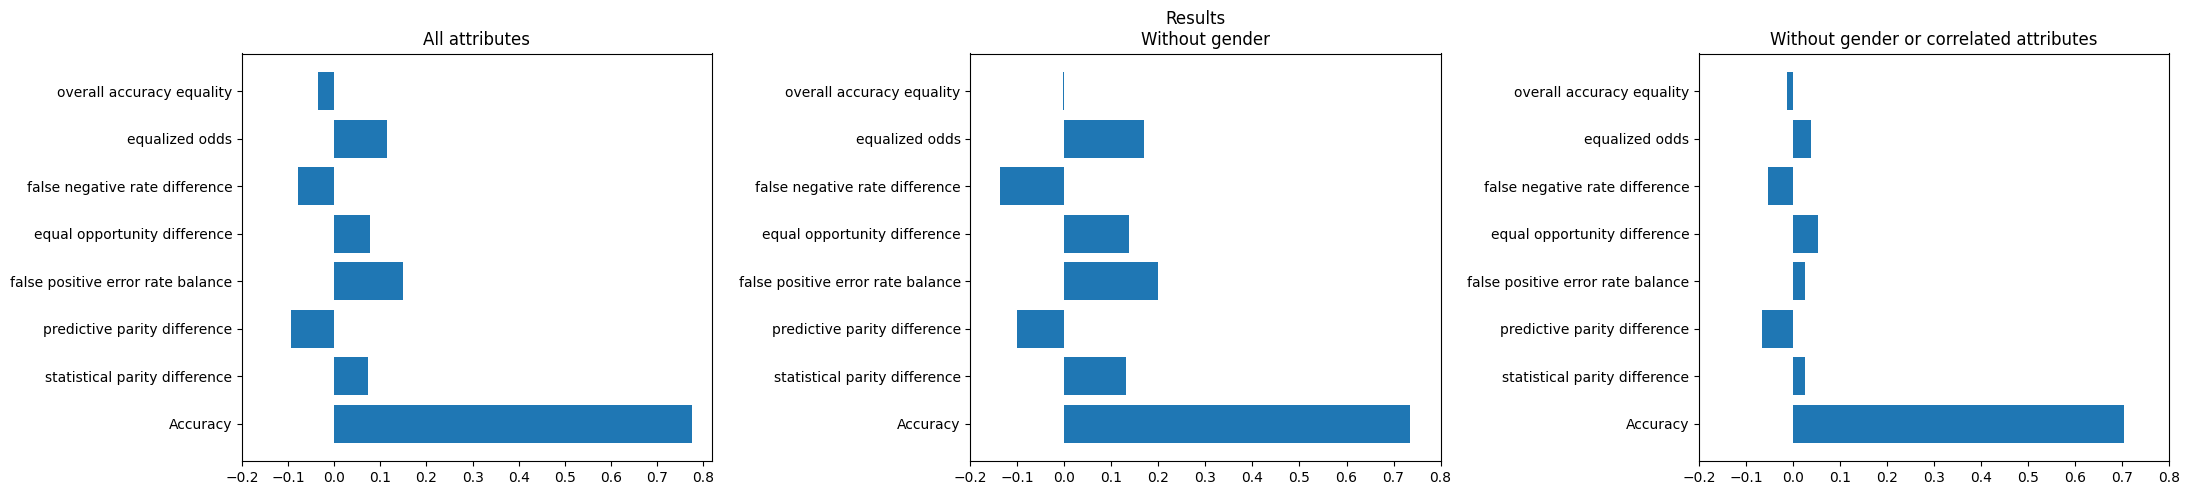

In [97]:
# results_1 = apply_metrics.fair_metrics(res_df_1)
# results_2 = apply_metrics.fair_metrics(res_df_2)
# results_3 = apply_metrics.fair_metrics(res_df_3)

plot_horizontal_dictionaries([final_results_1, final_results_2, final_results_3], title='Results',labels=['All attributes','Without gender','Without gender or correlated attributes'], errors=True)

1    700
2    300
Name: Class, dtype: int64

### 4.3 Accuracy depracation

In [235]:
dependent_attributes, independent_attributes = get_chi2(df4chi, class_name = 'status_and_sex', alpha = 0.05)
diff_dis_attributes, same_dis_attributes = get_mannwhitneyu(df4chi, class_name = 'status_and_sex', alpha = 0.05)

corr_attributes = {**independent_attributes, **same_dis_attributes, **dependent_attributes, **diff_dis_attributes}

corr_attributes = {k: v for k, v in sorted(corr_attributes.items(), key=lambda item: item[1], reverse=False)}
corr_attributes = [k for k,v in corr_attributes.items() if k not in ['status_and_sex','Class']]

avg_accuracies = []
avg_sp = []
results = []

while len(corr_attributes) > 1:
    df2 = df.copy()
    attributes = corr_attributes + ['status_and_sex','Class']
    df2 = process_data(df2[attributes])
    accuracies = []
    sp = []
    
    for i in range(10):
        X_train, X_test, y_train, y_test = split_data(df2, test_size = 0.1)
        #clf = train_model(X_train, y_train)
        clf = XGBClassifier()
        clf = clf.fit(X_train.loc[:, X_train.columns != 'gender'], y_train)
        y_pred = test_model(clf, X_test.loc[:, X_test.columns != 'gender'])
        accuracies.append(metrics.accuracy_score(y_test, y_pred))
        sp.append(apply_metrics.fair_metrics(get_res_df(X_test, y_test, y_pred))['statistical_parity_difference'])
    avg_accuracies.append(sum(accuracies)/len(accuracies))
    avg_sp.append(sum(sp)/len(sp))
#     res_df = get_res_df(X_test, y_test, y_pred)
#     results.append(apply_metrics.fair_metrics(res_df))
    
    corr_attributes.pop(0)
    
print(avg_accuracies)
print(avg_sp)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. 

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. 

[0.758, 0.767, 0.751, 0.7600000000000001, 0.75, 0.7139999999999999, 0.735, 0.713, 0.699, 0.709, 0.701, 0.7050000000000001, 0.7, 0.7140000000000002, 0.6930000000000001, 0.693, 0.685, 0.708]
[-0.07621993823974886, -0.10318143526444527, -0.034341261097690326, -0.0034509079162958977, -0.01739518813494918, -0.02511354317056306, -0.05045351911916844, 0.0014287176962735626, -0.05024616001076944, 0.00876503366203677, -0.015423229122613935, -0.039277650087873886, 0.03337313446614974, 0.017342683220630383, 0.0261311215812959, 0.017133557228377894, -0.01973704214223352, 0.03507088181268927]


In [ ]:
# [0.773, 0.733, 0.7809999999999999, 0.776, 0.7230000000000001, 0.734, 0.736, 0.7460000000000001, 0.736, 0.7190000000000001, 0.708, 0.701, 0.696, 0.6970000000000001, 0.707, 0.7040000000000001, 0.683, 0.696]

In [241]:
dependent_attributes, independent_attributes = get_chi2(df4chi, class_name = 'status_and_sex', alpha = 0.05)
diff_dis_attributes, same_dis_attributes = get_mannwhitneyu(df4chi, class_name = 'status_and_sex', alpha = 0.05)

corr_attributes = {**independent_attributes, **same_dis_attributes, **dependent_attributes, **diff_dis_attributes}

corr_attributes = {k: v for k, v in sorted(corr_attributes.items(), key=lambda item: item[1], reverse=False)}
corr_attributes = [k for k,v in corr_attributes.items() if k not in ['status_and_sex','Class']]

f_avg_accuracies = []
f_avg_sp = []
results = []

while len(corr_attributes) > 1:
    print(len(corr_attributes))
    
    df2 = df.copy()
    attributes = corr_attributes + ['status_and_sex','Class']
    df2 = process_data(df2[attributes])
    accuracies = []
    sp = []
    
    best_clf1, best_attributes1, best_acc, best_res_df1 = search_best_attributes(df2, class_name = 'Class',return_data = True, clf = XGBClassifier())
    accuracies.append(best_acc)
    sp.append(apply_metrics.fair_metrics(best_res_df1)['statistical_parity_difference'])
    print('Best acc:', best_acc)

    f_avg_accuracies.append(sum(accuracies)/len(accuracies))
    f_avg_sp.append(sum(sp)/len(sp))
#     res_df = get_res_df(X_test, y_test, y_pred)
#     results.append(apply_metrics.fair_metrics(res_df))
    
    corr_attributes.pop(0)
    
print(f_avg_accuracies)
print(f_avg_sp)

19


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. 

	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
	 20
	 21
	 22
	 23
	 24
	 25
	 26
	 27
	 28
	 29
	 30
	 31
	 32
	 33
	 34
	 35
	 36
	 37
	 38
	 39
	 40
	 41
	 42
	 43
	 44
	 45
	 46
	 47
	 48
	 49
	 50
	 51
	 52
	 53
	 54
	 55
	 56
	 57
	 58
Best acc: 0.805
18
	 0


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
	 20
	 21
	 22
	 23
	 24
	 25
	 26
	 27
	 28
	 29
	 30
	 31
	 32
	 33
	 34
	 35
	 36
	 37
	 38
	 39
	 40
	 41
	 42
	 43
	 44
	 45
	 46
	 47
	 48
	 49
	 50
	 51
	 52
	 53
	 54
	 55
Best acc: 0.795
17
	 0


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
	 20
	 21
	 22
	 23
	 24
	 25
	 26
	 27
	 28
	 29
	 30
	 31
	 32
	 33
	 34
	 35
	 36
	 37
	 38
	 39
	 40
	 41
	 42
	 43
	 44
	 45
	 46
	 47
	 48
	 49
	 50
	 51
	 52
	 53
	 54
Best acc: 0.78
16
	 0


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
	 20
	 21
	 22
	 23
	 24
	 25
	 26
	 27
	 28
	 29
	 30
	 31
	 32
	 33
	 34
	 35
	 36
	 37
	 38
	 39
	 40
	 41
	 42
	 43
	 44
	 45
	 46
	 47
	 48
	 49
	 50
	 51
	 52
	 53
Best acc: 0.79
15
	 0


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
	 20
	 21
	 22
	 23
	 24
	 25
	 26
	 27
	 28
	 29
	 30
	 31
	 32
	 33
	 34
	 35
	 36
	 37
	 38
	 39
	 40
	 41
	 42
	 43
	 44
	 45
	 46
	 47
	 48
Best acc: 0.79
14
	 0


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
	 20
	 21
	 22
	 23
	 24
	 25
	 26
	 27
	 28
	 29
	 30
	 31
	 32
	 33
	 34
	 35
	 36
	 37
	 38
	 39
	 40
	 41
	 42
	 43
	 44
	 45
	 46
	 47
Best acc: 0.81
13
	 0


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
	 20
	 21
	 22
	 23
	 24
	 25
	 26
	 27
	 28
	 29
	 30
	 31
	 32
	 33
	 34
	 35
	 36
	 37
	 38
	 39
	 40
	 41
	 42
	 43
	 44
	 45
	 46
Best acc: 0.8
12
	 0


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
	 20
	 21
	 22
	 23
	 24
	 25
	 26
	 27
	 28
	 29
	 30
	 31
	 32
	 33
	 34
	 35
	 36
Best acc: 0.77
11
	 0


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
	 20
	 21
	 22
	 23
	 24
	 25
	 26
	 27
	 28
	 29
	 30
	 31
Best acc: 0.79
10
	 0


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
	 20
	 21
	 22
	 23
	 24
	 25
	 26
	 27
	 28
	 29
	 30
Best acc: 0.765
9
	 0


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
	 20
	 21
	 22
	 23
	 24
	 25
	 26
	 27
	 28
Best acc: 0.805
8
	 0


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
	 20
	 21
	 22
	 23
	 24
	 25
	 26
	 27
Best acc: 0.795
7
	 0


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
	 20
	 21
	 22
	 23
Best acc: 0.78
6
	 0


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
	 18
	 19
Best acc: 0.79
5
	 0


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
	 15
	 16
	 17
Best acc: 0.77
4
	 0


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
	 13
	 14
Best acc: 0.7
3
	 0


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
Best acc: 0.75
2


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


	 0
	 1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
Best acc: 0.73
[0.805, 0.795, 0.78, 0.79, 0.79, 0.81, 0.8, 0.77, 0.79, 0.765, 0.805, 0.795, 0.78, 0.79, 0.77, 0.7, 0.75, 0.73]
[0.022543414949843577, 0.09609233764427749, 0.0649836372136513, -0.06190476190476191, -0.05642361111111116, 0.01923308089914655, 0.03774492126457507, 0.050595238095238027, -0.013915385478621922, -0.018382352941176516, 0.04729729729729726, -0.06096866096866094, -0.04388714733542309, -0.01085481682496614, -0.03179055633473582, 0.0, -0.03613511390416335, -0.3142857142857143]


In [ ]:
# [0.805, 0.795, 0.78, 0.79, 0.79, 0.81, 0.8, 0.77, 0.79, 0.765, 0.805, 0.795, 0.78, 0.79, 0.77, 0.7, 0.75, 0.73]

['housing', 'age', 'n_maintenance_people', 'employed_since', 'credit_amount', 'n_credits', 'purpose', 'credit_history', 'installment_rate', 'telephone', 'duration', 'job', 'property', 'foreign', 'other_installment_plans', 'savings', 'present_residence_since', 'status_current_account', 'other_debtors']


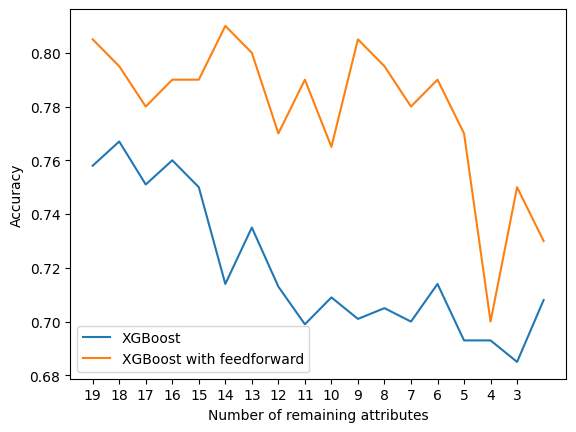

In [243]:
corr_attributes = {**independent_attributes, **same_dis_attributes, **dependent_attributes, **diff_dis_attributes}

corr_attributes = {k: v for k, v in sorted(corr_attributes.items(), key=lambda item: item[1], reverse=False)}
corr_attributes = [k for k,v in corr_attributes.items() if k not in ['status_and_sex','Class']]

plt.plot(avg_accuracies, label='XGBoost')
plt.plot(f_avg_accuracies, label='XGBoost with feedforward')
plt.xlabel('Number of remaining attributes')
plt.ylabel('Accuracy')
plt.xticks(ticks=range(len(corr_attributes)-2),labels=range(len(corr_attributes), 2, -1))
plt.legend()
print(corr_attributes)

['housing', 'age', 'n_maintenance_people', 'employed_since', 'credit_amount', 'n_credits', 'purpose', 'credit_history', 'installment_rate', 'telephone', 'duration', 'job', 'property', 'foreign', 'other_installment_plans', 'savings', 'present_residence_since', 'status_current_account', 'other_debtors']


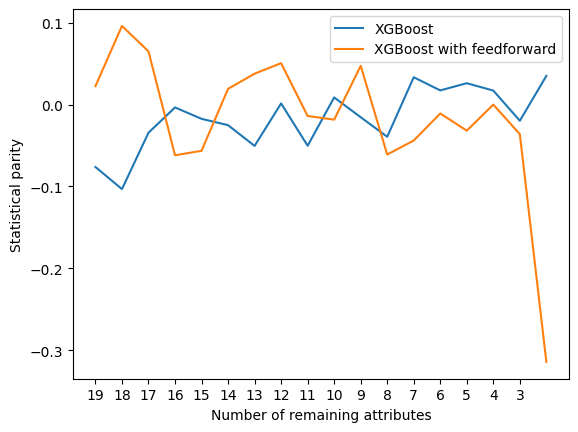

In [242]:
corr_attributes = {**independent_attributes, **same_dis_attributes, **dependent_attributes, **diff_dis_attributes}

corr_attributes = {k: v for k, v in sorted(corr_attributes.items(), key=lambda item: item[1], reverse=False)}
corr_attributes = [k for k,v in corr_attributes.items() if k not in ['status_and_sex','Class']]

plt.plot(avg_sp, label='XGBoost')
plt.plot(f_avg_sp, label='XGBoost with feedforward')
plt.xlabel('Number of remaining attributes')
plt.ylabel('Statistical parity')
plt.xticks(ticks=range(len(corr_attributes)-2),labels=range(len(corr_attributes), 2, -1))
plt.legend()
print(corr_attributes)

# OTHER

In [141]:
def search_best_attributes(df, class_name = 'Class', current_attributes = [], best_acc = -1, return_data = False, metric = 'accuracy', clf = None):

    for i in range(len(df.columns)):
        print('\t',i)
        for col_name in df.columns:
            if col_name not in current_attributes and col_name != class_name:
                attributes = current_attributes + [col_name]
                df2 = df.copy()

                # Split data
                X_train, X_test, y_train, y_test = split_data(df2, test_size = 0.20, y_name = class_name)
                X_train2 = X_train.copy()[attributes]
                X_test2 = X_test.copy()[attributes]
                
                # Train
                if clf == None:
                    clf = tree.DecisionTreeClassifier()
                
                clf = clf.fit(X_train2, y_train)

                # Test
                y_pred = clf.predict(X_test2)

                if metric == 'accuracy':
                    accuracy = metrics.accuracy_score(y_test, y_pred)
                elif metric == 'f1':
                    accuracy = metrics.f1_score(y_test, y_pred)

                if accuracy > best_acc:
                    best_clf = clf
                    best_attributes = current_attributes + [col_name]
                    best_acc = accuracy
                    best_res_df = get_res_df(X_test, y_test, y_pred)


        current_attributes = best_attributes
    
    if return_data == False:
        return best_clf, best_attributes, best_acc
    else:
        return best_clf, best_attributes, best_acc, best_res_df

## 5. Training following data science approaches

### 5.1. Best with all attributes

In [ ]:
accuracies = []
results = []

for i in range(100):
    X_train, X_test, y_train, y_test = split_data(df_preprocessed, test_size = 0.20)
    #clf = train_model(X_train, y_train)
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    y_pred = test_model(clf, X_test)
    accuracies.append(metrics.accuracy_score(y_test, y_pred))

    res_df = get_res_df(X_test, y_test, y_pred)
    results.append(apply_metrics.fair_metrics(res_df))

In [ ]:
print('Accuracy: ',sum(accuracies)/len(accuracies),'±', np.std(accuracies))
final_results_1 = {'Accuracy': (sum(accuracies)/len(accuracies),np.std(accuracies))}

for key in results[0].keys():
    print(f'{key}: {sum(r[key] for r in results) / len(results)} ± {np.std([r[key] for r in results])}')
    final_results_1[key] = (sum(r[key] for r in results) / len(results), np.std([r[key] for r in results]))

### 5.2. Best dependent from class

In [ ]:
df2 = df.copy()

dependent_attributes, independent_attributes = get_chi2(df4chi, class_name = 'Class', alpha = 0.05)
diff_dis_attributes, same_dis_attributes = get_mannwhitneyu(df4chi, class_name = 'Class', alpha = 0.05)

dependent_attributes = {**dependent_attributes, **diff_dis_attributes}

attributes = [k for k,v in dependent_attributes.items()]

df2 = process_data(df2[attributes])

accuracies = []
results = []

for i in range(100):
    best_clf1, best_attributes1, best_acc, best_res_df1 = search_best_attributes(df2, class_name = 'Class',return_data = True)
    accuracies.append(best_acc)
    
    res = apply_metrics.fair_metrics(best_res_df1)
    results.append(res)

In [ ]:
print('Accuracy: ',sum(accuracies)/len(accuracies),'±',np.std(accuracies))
final_results_2 = {'Accuracy': (sum(accuracies)/len(accuracies),np.std(accuracies))}

for key in results[0].keys():
    print(f'{key}: {sum(r[key] for r in results) / len(results)} ± {np.std([r[key] for r in results])}')
    final_results_2[key] = (sum(r[key] for r in results) / len(results), np.std([r[key] for r in results]))

### 5.3. Best classifier without dependent attributes from gender

In [ ]:
df2 = df.copy()

dependent_attributes, independent_attributes = get_chi2(df4chi, class_name = 'status_and_sex', alpha = 0.005)
diff_dis_attributes, same_dis_attributes = get_mannwhitneyu(df4chi, class_name = 'status_and_sex', alpha = 0.005)

# numeric_attributes = list(df4chi.select_dtypes(np.number).columns)
independent_attributes = {**independent_attributes, **same_dis_attributes}


attributes = [k for k,v in independent_attributes.items()] + ['status_and_sex'] #+ ['credit_amount']
# attributes.remove('foreign')
df2 = process_data(df2[attributes])

accuracies = []
results = []

for i in range(100):
    best_clf2, best_attributes2, best_acc, best_res_df2 = search_best_attributes_for_fairness(df2,protected_attribute='gender', class_name = 'Class')
    accuracies.append(best_acc)
    
    # Get metrics results
    res = apply_metrics.fair_metrics(best_res_df2)
    results.append(res)

In [ ]:
print('Accuracy: ',sum(accuracies)/len(accuracies),'±', np.std(accuracies))
final_results_3 = {'Accuracy': (sum(accuracies)/len(accuracies),np.std(accuracies))}

for key in results[0].keys():
    print(f'{key}: {sum(r[key] for r in results) / len(results)} ± {np.std([r[key] for r in results])}')
    final_results_3[key] = (sum(r[key] for r in results) / len(results), np.std([r[key] for r in results]))

### 5.4. Plot results

In [ ]:
# del final_results_1['treatment_equality_difference']
# del final_results_1['conditional_use_accuracy_equality']
# del final_results_2['treatment_equality_difference']
# del final_results_2['conditional_use_accuracy_equality']
# del final_results_3['treatment_equality_difference']
# del final_results_3['conditional_use_accuracy_equality']

plot_horizontal_dictionaries([final_results_1, final_results_2, final_results_3], title='Final Results',labels=['MAA','MCDA','MGIA'], errors=True)

In [ ]:
df2 = df.copy()

dependent_attributes, independent_attributes = get_chi2(df4chi, class_name = 'Class', alpha = 0.05)
diff_dis_attributes, same_dis_attributes = get_mannwhitneyu(df4chi, class_name = 'Class', alpha = 0.05)

dependent_attributes = {**dependent_attributes, **diff_dis_attributes}

attributes = [k for k,v in dependent_attributes.items()]
df2 = process_data(df2[attributes])

ba_dict = {}
for i in range(100):
    best_clf, best_attributes, best_acc = search_best_attributes(df2, class_name = 'Class')
    
    for a in best_attributes:
        if a in ba_dict:
            ba_dict[a] += 1
        else:
            ba_dict[a] = 1
            
{k: v for k, v in sorted(ba_dict.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
df2 = df.copy()

dependent_attributes, independent_attributes = get_chi2(df4chi, class_name = 'status_and_sex', alpha = 0.05)
diff_dis_attributes, same_dis_attributes = get_mannwhitneyu(df4chi, class_name = 'status_and_sex', alpha = 0.05)

independent_attributes = {**independent_attributes, **same_dis_attributes}

attributes = [k for k,v in independent_attributes.items()] + ['Class', 'status_and_sex']
df2 = process_data(df2[attributes])

ba_dict = {}

for i in range(100):
    best_clf, best_attributes, best_acc, best_res_df = search_best_attributes_for_fairness(df2,protected_attribute='gender', class_name = 'Class')
    
    for a in best_attributes:
        if a in ba_dict:
            ba_dict[a] += 1
        else:
            ba_dict[a] = 1
            
{k: v for k, v in sorted(ba_dict.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
stop

## 7. Conditional Fairness (new)

**Condition taken into account:** Credit amount > X

### 5.3.1. Equal opportunity

$ TPR = \frac{TP}{TP+FN} $

This implies that the probability of an applicant with an actual good credit score to be incorrectly assigned a a bad predicted credit score should be the same for both male and women

In [ ]:
conditional_fairness(best_res_df1, 'credit_amount', 'equal_opportunity_difference', increment = 10)

In [ ]:
conditional_fairness(best_res_df2, 'credit_amount', 'equal_opportunity_difference', increment = 10)

$ FNR = \frac{FN}{TP+FN} $ 

This implies that the probability of an applicant with an actual good credit score to be incorrectly assigned a a bad predicted credit score should be the same for both male and women

In [ ]:
conditional_fairness(best_res_df1, 'credit_amount', 'false_negative_rate_difference', increment = 10)

In [ ]:
conditional_fairness(best_res_df2, 'credit_amount', 'false_negative_rate_difference', increment = 10)

This means that along the condition, males have more chance to be assigned a bad predicted credit score having a good credit score.

### 5.3.2. Other metrics

#### Statistical parity difference

Equal probability of being assigned to the positive predicted class

In [ ]:
conditional_fairness(best_res_df1, 'credit_amount', 'statistical_parity_difference', increment = 10)

In [ ]:
conditional_fairness(best_res_df2, 'credit_amount', 'statistical_parity_difference', increment = 10)

This means women is not getting a good credit score after 8000 compared to men but before that, women has a higher proportion of positive predicted class.

#### Predictive parity difference

The probability of a subject with positive predicted value to truly belong to the positive class.

$PPV = \frac{TP}{TP+FP}$

In [ ]:
conditional_fairness(best_res_df1, 'credit_amount', 'predictive_parity_difference', increment = 10)

In [ ]:
conditional_fairness(best_res_df2, 'credit_amount', 'predictive_parity_difference', increment = 10)

More men than women are assigned good credit scores when they actually have it.

#### False positive error rate balance

The probability of a subject with an actual bad credit score to be incorrectly assigned a good credit score.

$FPR = \frac{FP}{FP+TN}$

In [ ]:
conditional_fairness(best_res_df1, 'credit_amount', 'false_positive_error_rate_balance', increment = 10)

In [ ]:
conditional_fairness(best_res_df2, 'credit_amount', 'false_positive_error_rate_balance', increment = 10)

Women have more chance to have a good credit score when they don't deserve it (positive discrimination around 20%).

#### Equalized odds

This definition combines False positive error rate balance and Equal Opportunity. This implies that the probability of an applicant with an actual good credit score to be correctly assigned a good predicted score and the probability of an applicant with an actual bad credit score to be incorrectly assigned a good predicted credit score should both be the same for privileged and unprivileged group.

$\tfrac{1}{2}\left[|FPR_{D = \text{unprivileged}} - FPR_{D = \text{privileged}}|
+ |TPR_{D = \text{unprivileged}} - TPR_{D = \text{privileged}}|\right]$

In [ ]:
conditional_fairness(best_res_df1, 'credit_amount', 'equalized_odds', increment = 10)

In [ ]:
conditional_fairness(best_res_df2, 'credit_amount', 'equalized_odds', increment = 10)

#### Conditional use accuracy equality

This definition also mix two conditions: Equal PPV and equal NPV. This implies that for both male and female applicants, the probability of an applicant with a good predicted credit score to actually have a good credit score and the probability of an applicant with a bad predicted credit score to actually have a bad credit score should be the same.

$\tfrac{1}{2}\left[|PPV_{D = \text{unprivileged}} - PPV_{D = \text{privileged}}|
+ |NPV_{D = \text{unprivileged}} - NPV_{D = \text{privileged}}|\right]$

In [ ]:
conditional_fairness(best_res_df1, 'credit_amount', 'conditional_use_accuracy_equality', increment = 10)

In [ ]:
conditional_fairness(best_res_df2, 'credit_amount', 'conditional_use_accuracy_equality', increment = 10)

#### Overall accuracy equality

Both groups must have similar accuracies.

In [ ]:
conditional_fairness(best_res_df1, 'credit_amount', 'overall_accuracy_equality', increment = 10)

In [ ]:
conditional_fairness(best_res_df2, 'credit_amount', 'overall_accuracy_equality', increment = 10)

#### Treatment equality difference

This metric evaluates the ratio of errors. Implying that ratio of FP to FN is the same for both groups.

$ TED = \frac{FN}{FP} $

In [ ]:
conditional_fairness(best_res_df1, 'credit_amount', 'treatment_equality_difference', increment = 10)

In [ ]:
conditional_fairness(best_res_df2, 'credit_amount', 'treatment_equality_difference', increment = 10)

# Conclusions

- **Conclusion 1**: The probability of an applicant with an actual good credit score to be incorrectly assigned a a bad predicted credit score is higher on males than females
- **Conclusion 2**: Women has a higher proportion of positive predicted class.
- **Conclusion 3**: Women have more chance to have a good credit score when they don't deserve it (positive discrimination around 20%).

# Questions

- **Conditional definition in paper**: This definition extends statistical parity by permitting a set of legitimate attributes to affect the outcome. The definition is satisfied if subjects in both protected and unprotected groups have equal probability of being assigned to the positive predicted class, controlling for a set of legitimate factors L.


- **Small test**: Maybe discrimination increases because there are only 3 individuals up to 3000 credit amount and the women is rejected. (thats probably happening after 8000$) -> After 8000 **only one female** (Bad credit predicted and assigned)


- **What the condition truly means**: What is the point of using fairness metric if checking the progress through a condition we find unfairness. Maybe try mitigation techniques or a bigger dataset.

In [ ]:
show_histogram(res_df, 'credit_amount')

In [ ]:
res_df[res_df['credit_amount'] >= 8000]